In [1]:
#!pip install scikeras

In [2]:
#!pip install keras_tuner

In [3]:
#!pip install --upgrade tensorflow


In [4]:
#!pip install --upgrade numpy


# 0. Initial Setup

In [5]:
# Data Handling and Visualization Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# Machine Learning and Deep Learning Libraries
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from scikeras.wrappers import KerasClassifier, KerasRegressor
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import keras_tuner as kt

# Statistical and Causal Inference Libraries
from scipy.stats import ks_2samp, spearmanr
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.api import VAR
import tigramite
from knockoffs import Knockoffs
import torch

# Custom Modules
from diagnostics import compute_diagnostics, ScatterCovariance
from functions import deseasonalize

# Utility Libraries
import pickle
import pathlib

from tigramite import data_processing as pp
from tigramite.lpcmci import LPCMCI
from tigramite.independence_tests.parcorr import ParCorr
from tigramite.independence_tests.gpdc import GPDC
from tigramite.independence_tests.gpdc_torch import GPDCtorch
from tigramite import plotting as tp
from tigramite.models import Models
from tigramite.causal_effects import CausalEffects

In [6]:
keras.utils.set_random_seed(585)

# 1. EDA and Data Preprocessing

In [7]:
raw = pd.read_csv('cs_2_daily_data.csv')

In [8]:
raw

,DateTime,Day of the Week,Followers,Players,Average Players,Twitch Viewers,Positive reviews,Negative reviews,Rating,Final price,...,Top channel,2nd channel,3rd channel,4th channel,5th channel,Channels 6-10,Channels 11-25,Channels 26-50,Channels 51-100,Channels 101-250
0,9/2/15,Wednesday,NaN,564619,NaN,160301,1484.0,-97.0,94.729678,14.99,...,15082.0,8043.0,5084.0,3773.0,2881.0,8204.0,7780.0,3724.0,2384.0,1697.0
1,9/3/15,Thursday,NaN,570566,NaN,123795,1251.0,-92.0,94.726721,14.99,...,13695.0,7290.0,4971.0,3459.0,2531.0,7150.0,7772.0,3949.0,2280.0,1613.0
2,9/4/15,Friday,NaN,587280,NaN,151370,1394.0,-93.0,94.724693,14.99,...,20763.0,7350.0,3505.0,2475.0,1980.0,6067.0,7176.0,4241.0,2657.0,1774.0
3,9/5/15,Saturday,NaN,629407,NaN,182653,1397.0,-98.0,94.722037,14.99,...,31345.0,13955.0,5745.0,4150.0,2924.0,8760.0,8244.0,4679.0,2980.0,2182.0
4,9/6/15,Sunday,NaN,653346,NaN,93924,1697.0,-123.0,94.718308,14.99,...,14173.0,6406.0,3654.0,3073.0,2448.0,7776.0,9399.0,5345.0,3191.0,2224.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3190,5/27/24,Monday,4075307.0,1510630,1.052449e+06,265027,1143.0,-324.0,87.200752,0.00,...,15424.0,9982.0,7376.0,5819.0,4086.0,11647.0,13295.0,7790.0,5699.0,4223.0
3191,5/28/24,Tuesday,4075967.0,1487428,1.012629e+06,260669,1052.0,-299.0,87.199189,0.00,...,17804.0,11837.0,7030.0,5555.0,4738.0,13676.0,14666.0,8539.0,6528.0,4599.0
3192,5/29/24,Wednesday,4076596.0,1543247,9.856374e+05,302134,1655.0,-471.0,87.196725,0.00,...,18888.0,12234.0,8541.0,7162.0,6322.0,18082.0,16483.0,9747.0,6790.0,5024.0
3193,5/30/24,Thursday,4077314.0,1465460,9.876805e+05,178872,553.0,-138.0,87.196112,0.00,...,9092.0,6220.0,4825.0,2801.0,2457.0,8444.0,11115.0,7218.0,5670.0,4490.0


In [9]:
raw.columns

Index(['DateTime', 'Day of the Week', 'Followers', 'Players',
       'Average Players', 'Twitch Viewers', 'Positive reviews',
       'Negative reviews', 'Rating', 'Final price', 'Historical low',
       'Original price', 'discount', 'Free Weekend / Free Week',
       'Tournament (INTL)', 'Events', 'Peak viewers', 'Average viewers',
       'Peak channels', 'Average channels',
       'Viewer ratio (Average view / Average Channel)', 'Top channel',
       '2nd channel', '3rd channel', '4th channel', '5th channel',
       'Channels 6-10', 'Channels 11-25', 'Channels 26-50', 'Channels 51-100',
       'Channels 101-250'],
      dtype='object')

In [10]:
raw.isnull().sum()

DateTime                                            0
Day of the Week                                     0
Followers                                        1417
Players                                             0
Average Players                                  2578
Twitch Viewers                                      0
Positive reviews                                  295
Negative reviews                                  255
Rating                                              0
Final price                                         0
Historical low                                      0
Original price                                      0
discount                                            0
Free Weekend / Free Week                         3195
Tournament (INTL)                                3031
Events                                           3186
Peak viewers                                        0
Average viewers                                     0
Peak channels               

In [11]:
raw[['Final price', 'Historical low',
       'Original price', 'discount']]

,Final price,Historical low,Original price,discount
0,14.99,3.74,14.99,0.0
1,14.99,3.74,14.99,0.0
2,14.99,3.74,14.99,0.0
3,14.99,3.74,14.99,0.0
4,14.99,3.74,14.99,0.0
...,...,...,...,...
3190,0.00,0.00,0.00,0.0
3191,0.00,0.00,0.00,0.0
3192,0.00,0.00,0.00,0.0
3193,0.00,0.00,0.00,0.0


In [12]:
# turn tournaments and events into binary

raw['Tournament (INTL)'] = np.where(raw['Tournament (INTL)'].notnull(), 1, 0)
raw['Events'] = np.where(raw['Events'].notnull(), 1, 0)

In [13]:
# turn day of week into dummy variable
day_of_week = pd.get_dummies(raw['Day of the Week']).astype(int)

raw = pd.concat([raw, day_of_week], axis=1)

In [14]:
raw['is_historical_low'] = np.where(raw['Final price'] == raw['Historical low'], 1, 0)

In [15]:
predictors = ['Peak viewers', 'Rating', 'Final price', 'is_historical_low']
target = 'Players'

In [16]:
df = raw[predictors + [target] + ['DateTime']]

In [17]:
df.loc[:, 'DateTime'] = pd.to_datetime(df['DateTime'], format='%m/%d/%y')

In [18]:
df = df.set_index('DateTime')

In [19]:
df

,Peak viewers,Rating,Final price,is_historical_low,Players
DateTime,,,,,
2015-09-02,160301,94.729678,14.99,0,564619
2015-09-03,123795,94.726721,14.99,0,570566
2015-09-04,151370,94.724693,14.99,0,587280
2015-09-05,182653,94.722037,14.99,0,629407
2015-09-06,93924,94.718308,14.99,0,653346
...,...,...,...,...,...
2024-05-27,260822,87.200752,0.00,1,1510630
2024-05-28,259524,87.199189,0.00,1,1487428
2024-05-29,309661,87.196725,0.00,1,1543247


In [20]:
df.columns

Index(['Peak viewers', 'Rating', 'Final price', 'is_historical_low',
       'Players'],
      dtype='object')

In [21]:
# List of columns to calculate difference
columns_to_diff = [col for col in df.columns if col != 'is_historical_low']

# Calculate the difference
df_diff = df[columns_to_diff].diff()

# If you want to keep the 'is_historical_low' column in the final dataframe
df_diff['is_historical_low'] = df['is_historical_low']

# Display the resulting dataframe
df_diff

,Peak viewers,Rating,Final price,Players,is_historical_low
DateTime,,,,,
2015-09-02,NaN,NaN,NaN,NaN,0
2015-09-03,-36506.0,-0.002957,0.0,5947.0,0
2015-09-04,27575.0,-0.002028,0.0,16714.0,0
2015-09-05,31283.0,-0.002655,0.0,42127.0,0
2015-09-06,-88729.0,-0.003729,0.0,23939.0,0
...,...,...,...,...,...
2024-05-27,179523.0,-0.001689,0.0,-61464.0,1
2024-05-28,-1298.0,-0.001563,0.0,-23202.0,1
2024-05-29,50137.0,-0.002464,0.0,55819.0,1


In [22]:
df_diff = df_diff.dropna()

In [23]:
df_diff

,Peak viewers,Rating,Final price,Players,is_historical_low
DateTime,,,,,
2015-09-03,-36506.0,-0.002957,0.0,5947.0,0
2015-09-04,27575.0,-0.002028,0.0,16714.0,0
2015-09-05,31283.0,-0.002655,0.0,42127.0,0
2015-09-06,-88729.0,-0.003729,0.0,23939.0,0
2015-09-07,-17402.0,-0.001689,0.0,-2888.0,0
...,...,...,...,...,...
2024-05-27,179523.0,-0.001689,0.0,-61464.0,1
2024-05-28,-1298.0,-0.001563,0.0,-23202.0,1
2024-05-29,50137.0,-0.002464,0.0,55819.0,1


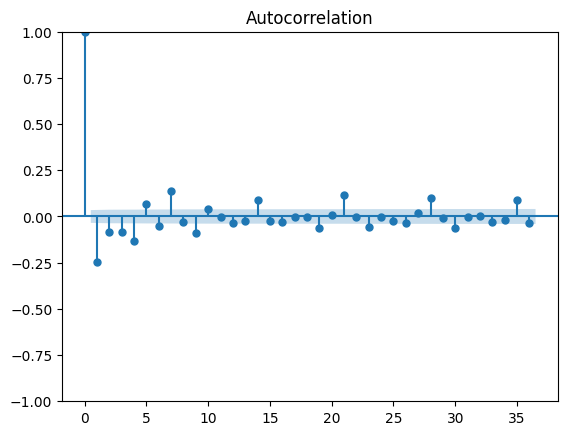

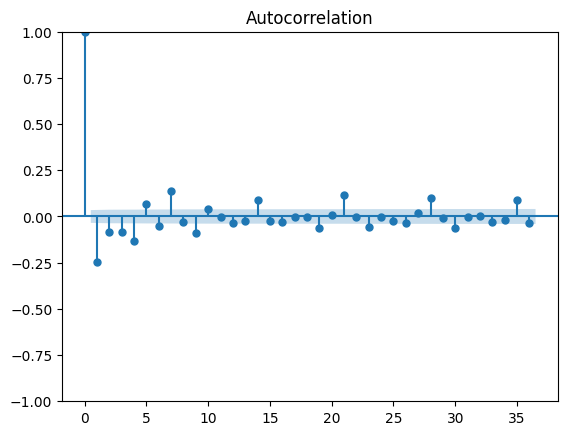

In [24]:
plot_acf(df_diff['Peak viewers'])

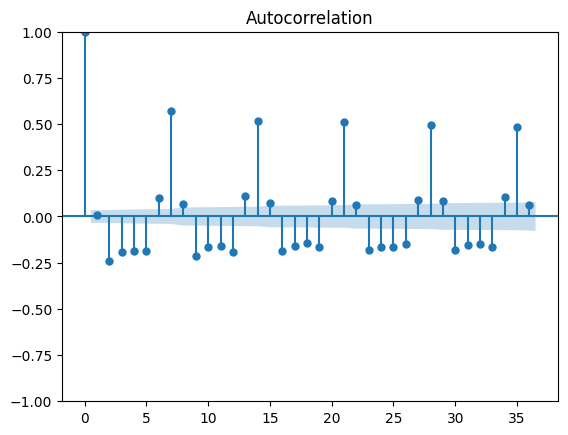

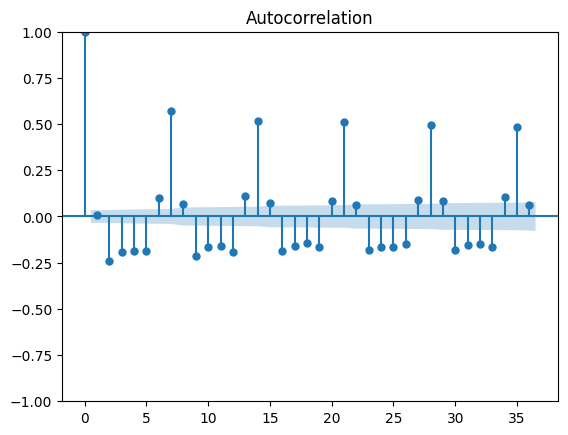

In [25]:
plot_acf(df_diff['Players'])

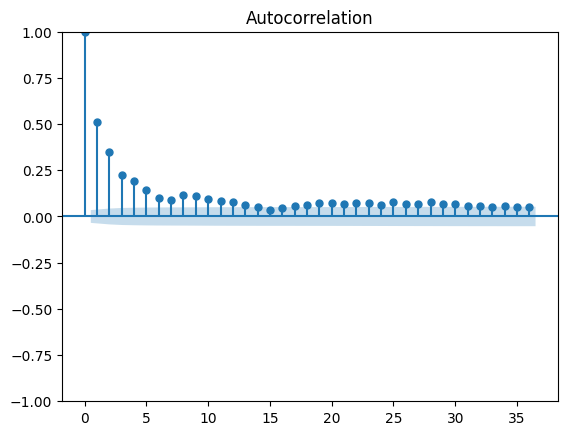

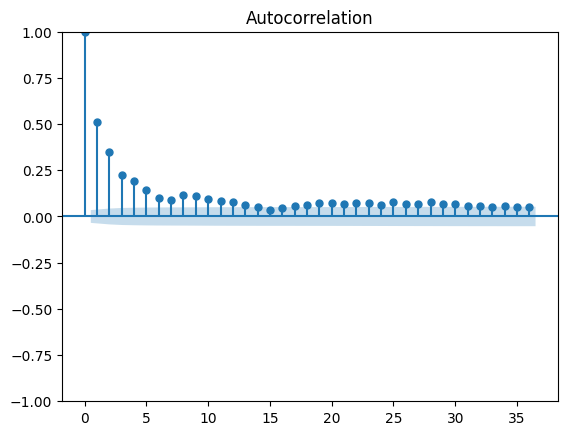

In [26]:
plot_acf(df_diff['Rating'])

In [27]:
Players = df_diff[['Players']]

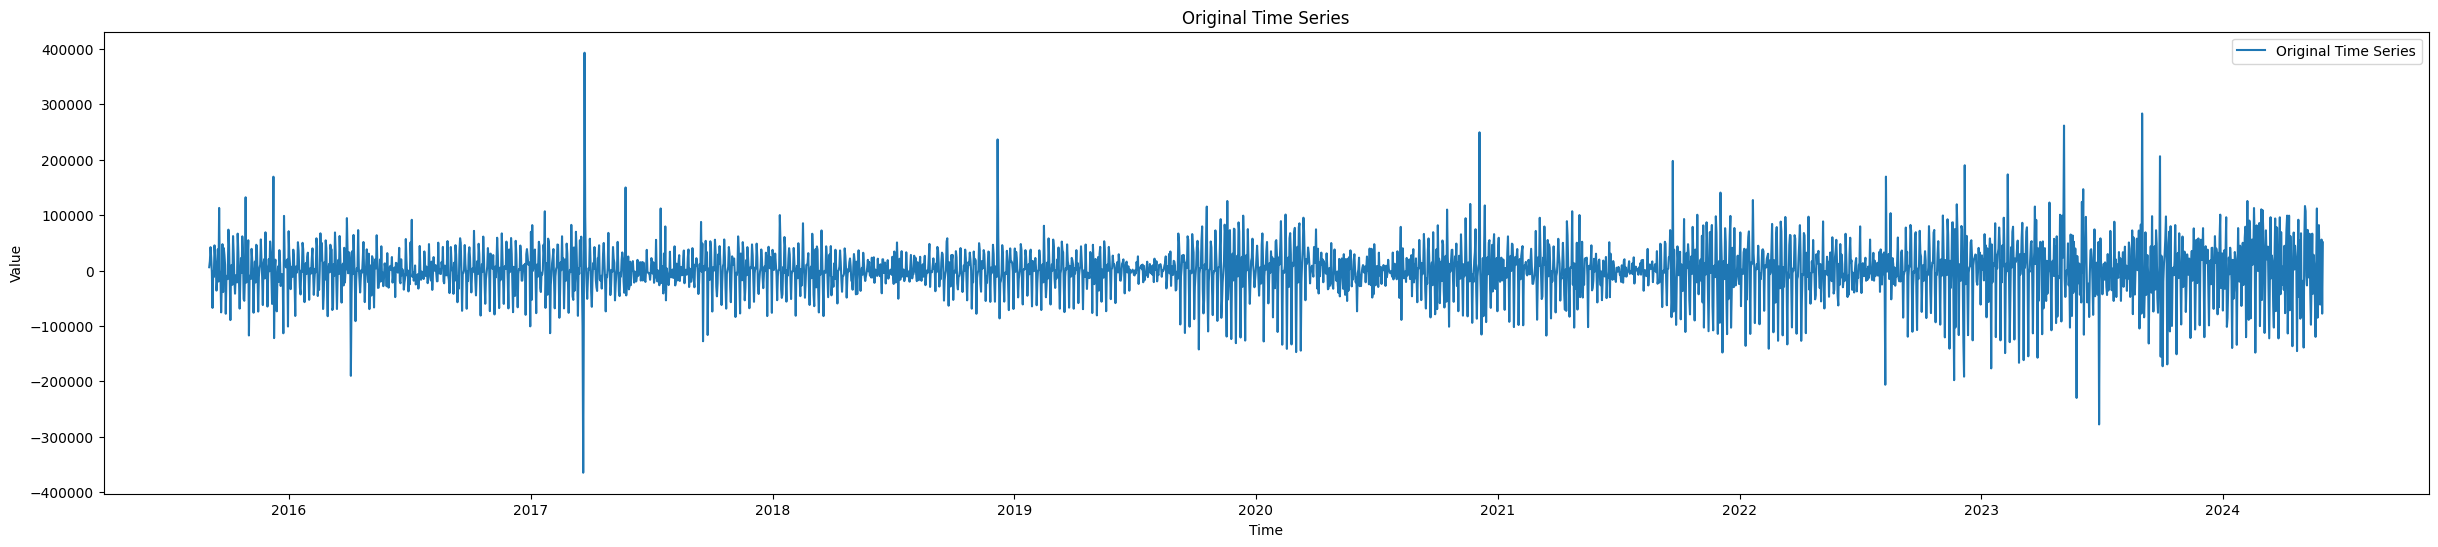

In [28]:
# Plot the original time series
plt.figure(figsize=(30, 6))
plt.plot(Players, label='Original Time Series')
plt.title('Original Time Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

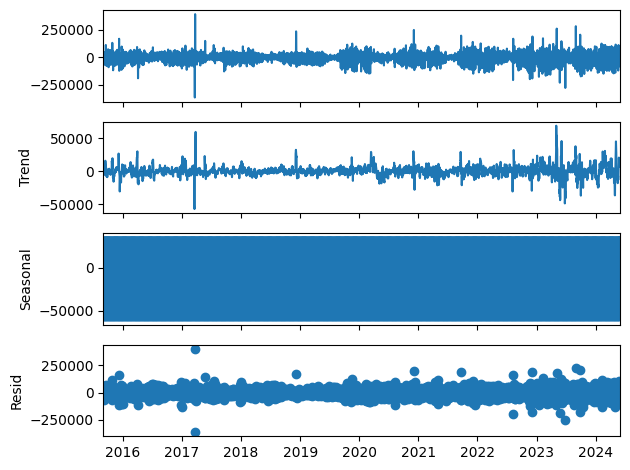

In [29]:
# Decompose the time series
result = seasonal_decompose(Players, model='additive', period = 7)

# Plot the decomposed components
result.plot()
plt.show()

In [30]:
# Deseasonalize the time series
deseasonalized_player = Players['Players'] - result.seasonal

In [31]:
deseasonalized_player

DateTime
2015-09-03     9102.880584
2015-09-04   -18387.409526
2015-09-05    16763.681212
2015-09-06    22840.387367
2015-09-07    58329.082542
                  ...     
2024-05-27     -246.917458
2024-05-28   -17267.460691
2024-05-29    47074.838512
2024-05-30   -74631.119416
2024-05-31    15676.590474
Length: 3194, dtype: float64

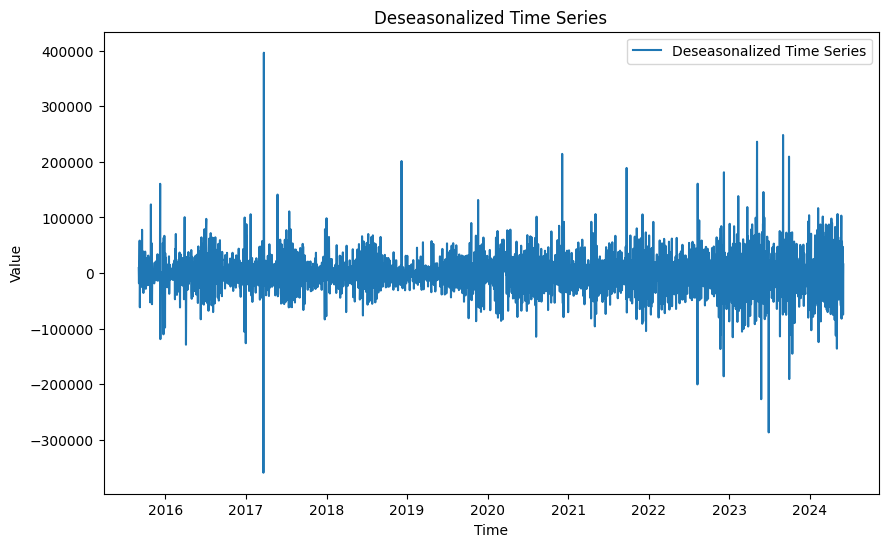

In [32]:
# Plot the deseasonalized time series
plt.figure(figsize=(10, 6))
plt.plot(deseasonalized_player, label='Deseasonalized Time Series')
plt.title('Deseasonalized Time Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [33]:
df_diff = pd.concat([df_diff, deseasonalized_player], axis=1)

In [34]:
df_diff

,Peak viewers,Rating,Final price,Players,is_historical_low,0
DateTime,,,,,,
2015-09-03,-36506.0,-0.002957,0.0,5947.0,0,9102.880584
2015-09-04,27575.0,-0.002028,0.0,16714.0,0,-18387.409526
2015-09-05,31283.0,-0.002655,0.0,42127.0,0,16763.681212
2015-09-06,-88729.0,-0.003729,0.0,23939.0,0,22840.387367
2015-09-07,-17402.0,-0.001689,0.0,-2888.0,0,58329.082542
...,...,...,...,...,...,...
2024-05-27,179523.0,-0.001689,0.0,-61464.0,1,-246.917458
2024-05-28,-1298.0,-0.001563,0.0,-23202.0,1,-17267.460691
2024-05-29,50137.0,-0.002464,0.0,55819.0,1,47074.838512


In [35]:
df_diff.columns = ['Peak viewers', 'Rating', 'Final price',	'Players', 'is_historical_low', 'Deseasonalized_players']

In [36]:
df_diff = df_diff.drop('Players', axis = 1)

In [37]:
df_diff

,Peak viewers,Rating,Final price,is_historical_low,Deseasonalized_players
DateTime,,,,,
2015-09-03,-36506.0,-0.002957,0.0,0,9102.880584
2015-09-04,27575.0,-0.002028,0.0,0,-18387.409526
2015-09-05,31283.0,-0.002655,0.0,0,16763.681212
2015-09-06,-88729.0,-0.003729,0.0,0,22840.387367
2015-09-07,-17402.0,-0.001689,0.0,0,58329.082542
...,...,...,...,...,...
2024-05-27,179523.0,-0.001689,0.0,1,-246.917458
2024-05-28,-1298.0,-0.001563,0.0,1,-17267.460691
2024-05-29,50137.0,-0.002464,0.0,1,47074.838512


In [38]:
def check_stationarity(data):
    result = adfuller(data)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [39]:
check_stationarity(df_diff['Deseasonalized_players'])

ADF Statistic: -10.296871712722155
p-value: 3.452822842311134e-18
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


<Axes: >

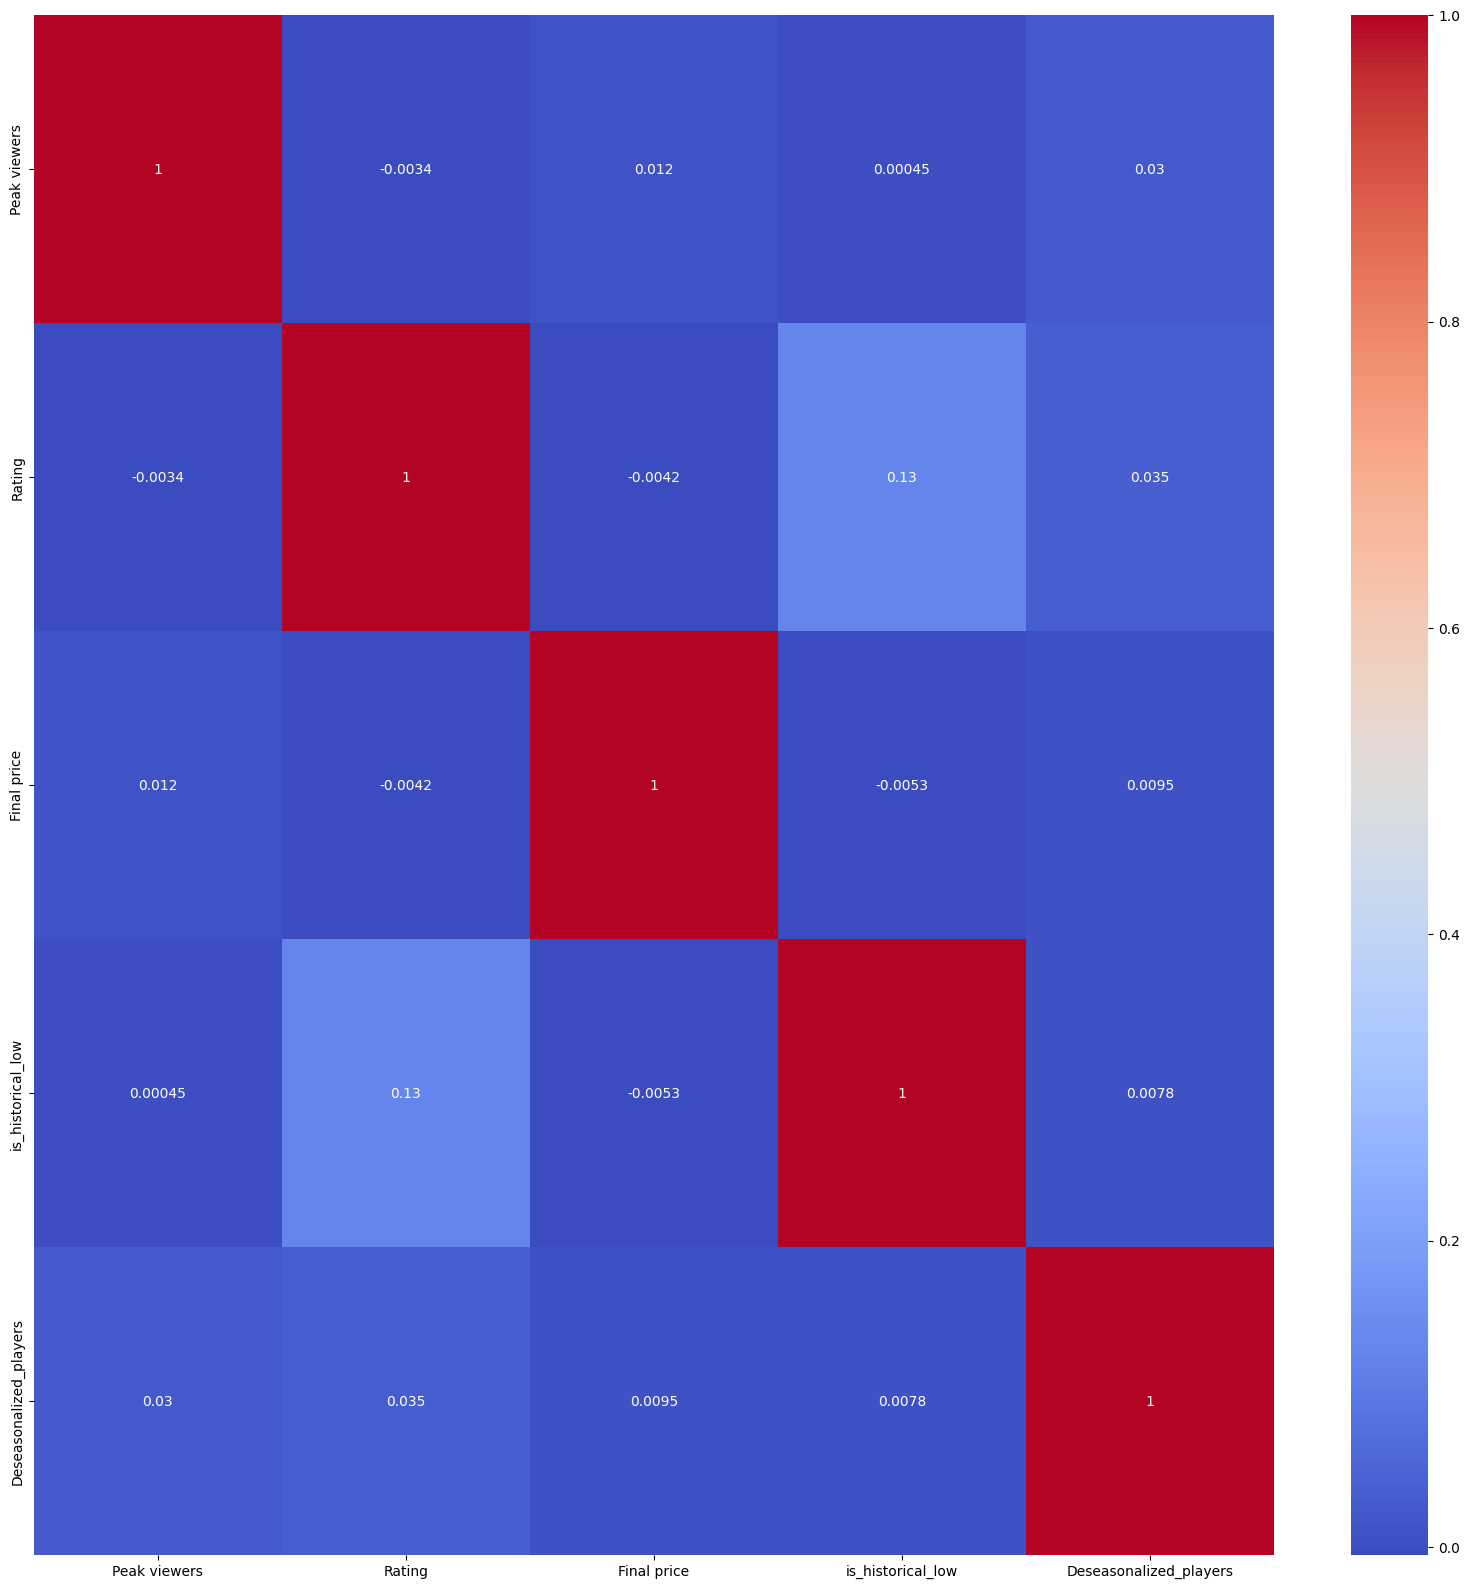

In [40]:
plt.figure(figsize=(20, 20))
sns.heatmap(df_diff.corr(),
            annot = True,
            cmap = 'coolwarm')

In [41]:
for i in range(1,15):
    df_diff['Peak viewers_shift_' + str(i)] = df_diff['Peak viewers'].shift(i)
for i in range(1,8):
    df_diff['Rating_shift_' + str(i)] = df_diff['Rating'].shift(i)
for i in range(1,8):
    df_diff['Final price_shift_' + str(i)] = df_diff['Final price'].shift(i)
for i in range(1,8):
    df_diff['is_historical_low_shift_' + str(i)] = df_diff['is_historical_low'].shift(i)

In [42]:
df_diff = df_diff.dropna()

<Axes: >

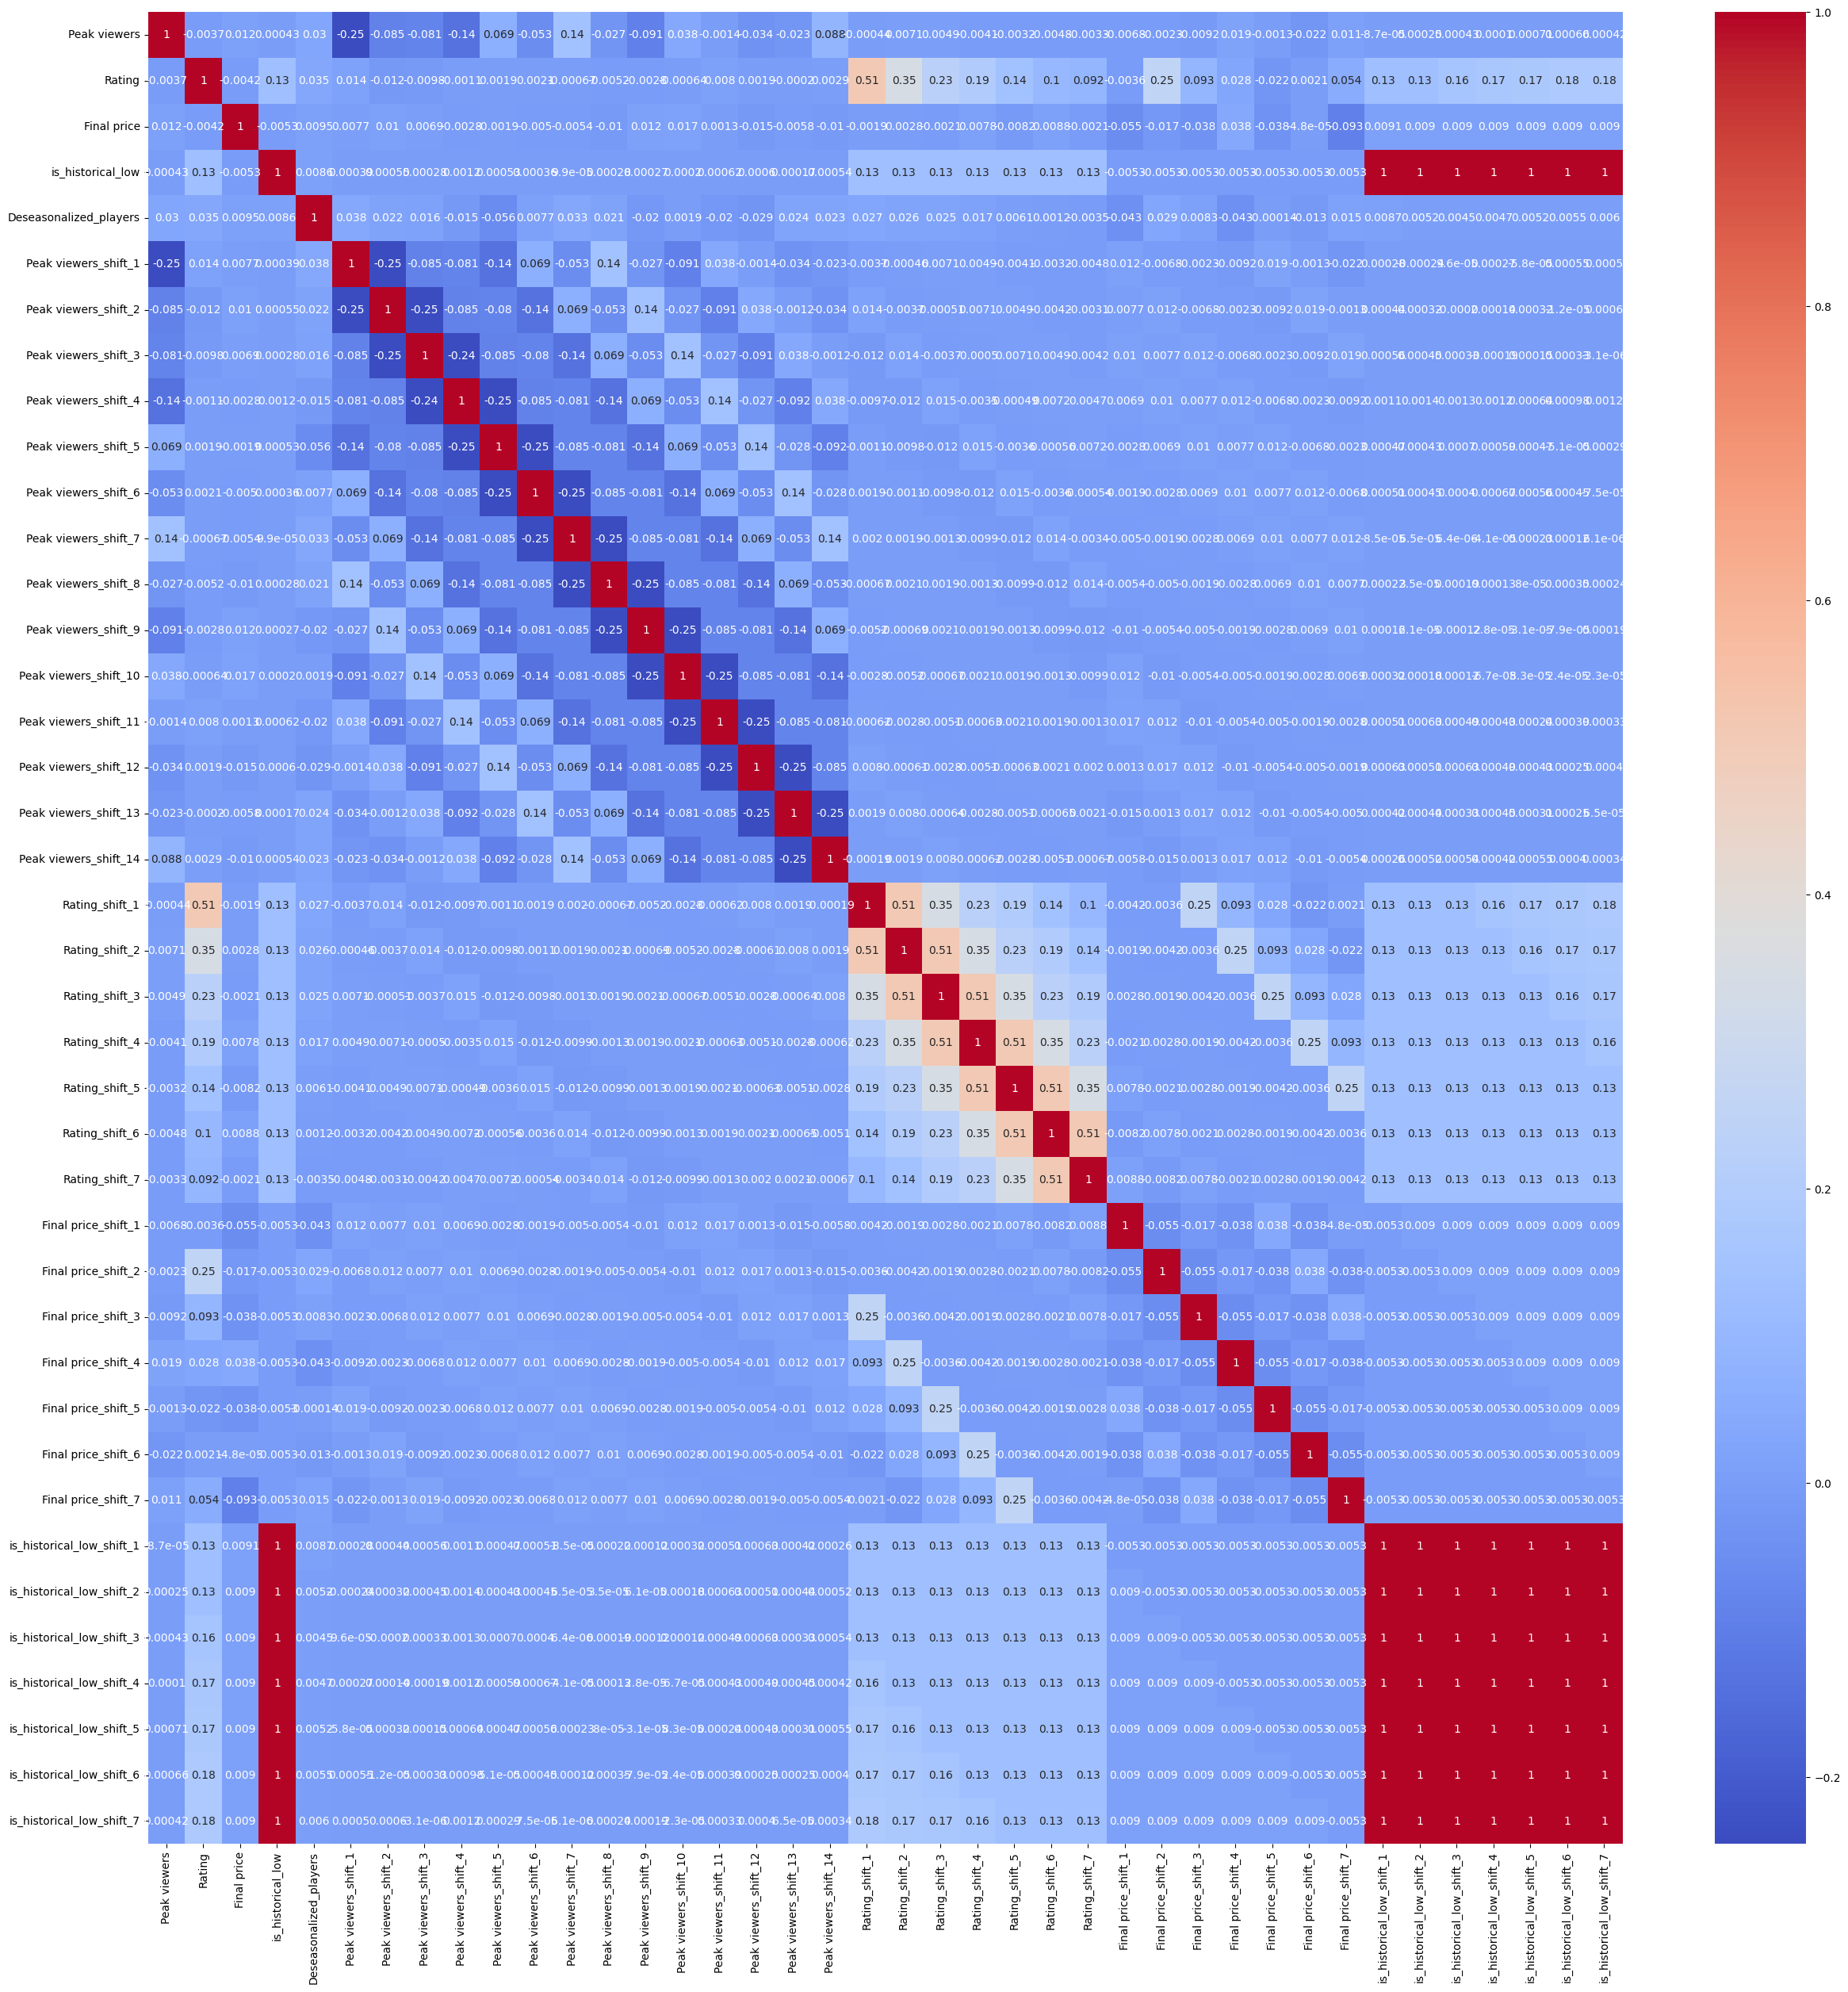

In [43]:
plt.figure(figsize=(30, 30))
sns.heatmap(df_diff.corr(),
            annot = True,
            cmap = 'coolwarm')

In [44]:
df_diff.columns

Index(['Peak viewers', 'Rating', 'Final price', 'is_historical_low',
       'Deseasonalized_players', 'Peak viewers_shift_1',
       'Peak viewers_shift_2', 'Peak viewers_shift_3', 'Peak viewers_shift_4',
       'Peak viewers_shift_5', 'Peak viewers_shift_6', 'Peak viewers_shift_7',
       'Peak viewers_shift_8', 'Peak viewers_shift_9', 'Peak viewers_shift_10',
       'Peak viewers_shift_11', 'Peak viewers_shift_12',
       'Peak viewers_shift_13', 'Peak viewers_shift_14', 'Rating_shift_1',
       'Rating_shift_2', 'Rating_shift_3', 'Rating_shift_4', 'Rating_shift_5',
       'Rating_shift_6', 'Rating_shift_7', 'Final price_shift_1',
       'Final price_shift_2', 'Final price_shift_3', 'Final price_shift_4',
       'Final price_shift_5', 'Final price_shift_6', 'Final price_shift_7',
       'is_historical_low_shift_1', 'is_historical_low_shift_2',
       'is_historical_low_shift_3', 'is_historical_low_shift_4',
       'is_historical_low_shift_5', 'is_historical_low_shift_6',
       'is_h

# 2. Linear Regression

In [45]:
df_linreg = raw[['Players', 'Day of the Week', 'Peak viewers', 'Rating', 'Final price', 'Tournament (INTL)', 'Events', 'is_historical_low', 'Friday', 'Monday', 'Saturday',
       'Sunday', 'Thursday', 'Tuesday', 'Wednesday']]

In [46]:
# stationarize
df_linreg['Players'] = df_linreg['Players'].diff().dropna()
df_linreg['Peak viewers'] = df_linreg['Peak viewers'].diff().dropna()
df_linreg['Rating'] = df_linreg['Rating'].diff().dropna()
df_linreg['Final price'] = df_linreg['Final price'].diff().dropna()

In [47]:
df_linreg = df_linreg.iloc[1:]

In [48]:
df_linreg

,Players,Day of the Week,Peak viewers,Rating,Final price,Tournament (INTL),Events,is_historical_low,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
1,5947.0,Thursday,-36506.0,-0.002957,0.0,0,0,0,0,0,0,0,1,0,0
2,16714.0,Friday,27575.0,-0.002028,0.0,0,0,0,1,0,0,0,0,0,0
3,42127.0,Saturday,31283.0,-0.002655,0.0,0,0,0,0,0,1,0,0,0,0
4,23939.0,Sunday,-88729.0,-0.003729,0.0,0,0,0,0,0,0,1,0,0,0
5,-2888.0,Monday,-17402.0,-0.001689,0.0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3190,-61464.0,Monday,179523.0,-0.001689,0.0,0,0,1,0,1,0,0,0,0,0
3191,-23202.0,Tuesday,-1298.0,-0.001563,0.0,0,0,1,0,0,0,0,0,1,0
3192,55819.0,Wednesday,50137.0,-0.002464,0.0,0,0,1,0,0,0,0,0,0,1
3193,-77787.0,Thursday,-127648.0,-0.000614,0.0,0,0,1,0,0,0,0,1,0,0


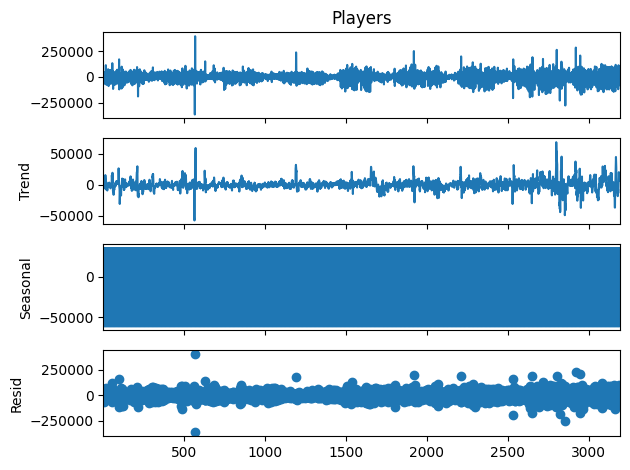

In [49]:
# Decompose the time series
result = seasonal_decompose(df_linreg['Players'], model='additive', period = 7)

# Plot the decomposed components
result.plot()
plt.show()

In [50]:
df_linreg['Deseasonalized_players'] = df_linreg['Players'] - result.seasonal

In [51]:
df_granger = df_linreg

In [52]:
for i in range(1,15):
    df_linreg['Peak viewers_shift_' + str(i)] = df_linreg['Peak viewers'].shift(i)
for i in range(1,8):
    df_linreg['Rating_shift_' + str(i)] = df_linreg['Rating'].shift(i)
for i in range(1,8):
    df_linreg['Final price_shift_' + str(i)] = df_linreg['Final price'].shift(i)
for i in range(1,8):
    df_linreg['is_historical_low_shift_' + str(i)] = df_linreg['is_historical_low'].shift(i)

In [53]:
df_linreg = df_linreg.dropna()

In [54]:
day_mapping = {
    'Monday': 1,
    'Tuesday': 2,
    'Wednesday': 3,
    'Thursday': 4,
    'Friday': 5,
    'Saturday': 6,
    'Sunday': 7
}
df_linreg['Day of the Week'] = df_linreg['Day of the Week'].map(day_mapping)

In [55]:
# model 1
x_1 = df_linreg[['Peak viewers', 'Rating', 'Final price',
       'Tournament (INTL)', 'Events', 'is_historical_low', 'Friday', 'Monday',
       'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'Peak viewers_shift_1',
       'Peak viewers_shift_2', 'Peak viewers_shift_3', 'Peak viewers_shift_4',
       'Peak viewers_shift_5', 'Peak viewers_shift_6', 'Peak viewers_shift_7',
       'Peak viewers_shift_8', 'Peak viewers_shift_9', 'Peak viewers_shift_10',
       'Peak viewers_shift_11', 'Peak viewers_shift_12',
       'Peak viewers_shift_13', 'Peak viewers_shift_14', 'Rating_shift_1',
       'Rating_shift_2', 'Rating_shift_3', 'Rating_shift_4', 'Rating_shift_5',
       'Rating_shift_6', 'Rating_shift_7', 'Final price_shift_1',
       'Final price_shift_2', 'Final price_shift_3', 'Final price_shift_4',
       'Final price_shift_5', 'Final price_shift_6', 'Final price_shift_7',
       'is_historical_low_shift_1', 'is_historical_low_shift_2',
       'is_historical_low_shift_3', 'is_historical_low_shift_4',
       'is_historical_low_shift_5', 'is_historical_low_shift_6',
       'is_historical_low_shift_7']]

y = df_linreg['Deseasonalized_players']

x_1 = sm.add_constant(x_1)

model_1 = sm.OLS(y, x_1)
print(model_1.fit().summary())

                              OLS Regression Results                              
Dep. Variable:     Deseasonalized_players   R-squared:                       0.035
Model:                                OLS   Adj. R-squared:                  0.021
Method:                     Least Squares   F-statistic:                     2.448
Date:                    Thu, 11 Jul 2024   Prob (F-statistic):           1.82e-07
Time:                            21:14:52   Log-Likelihood:                -37879.
No. Observations:                    3180   AIC:                         7.585e+04
Df Residuals:                        3132   BIC:                         7.614e+04
Df Model:                              47                                         
Covariance Type:                nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

In [56]:
# model 2  with only Peak viewers and its lags
x_2 = df_linreg[['Peak viewers', 'Peak viewers_shift_1', 'Peak viewers_shift_2', 'Peak viewers_shift_3',
       'Peak viewers_shift_4', 'Peak viewers_shift_5', 'Peak viewers_shift_6',
       'Peak viewers_shift_7', 'Peak viewers_shift_8', 'Peak viewers_shift_9',
       'Peak viewers_shift_10', 'Peak viewers_shift_11',
       'Peak viewers_shift_12', 'Peak viewers_shift_13',
       'Peak viewers_shift_14']]
y = df_linreg['Deseasonalized_players']

x_2 = sm.add_constant(x_2)

model_2 = sm.OLS(y, x_2)
print(model_2.fit().summary())

                              OLS Regression Results                              
Dep. Variable:     Deseasonalized_players   R-squared:                       0.011
Model:                                OLS   Adj. R-squared:                  0.006
Method:                     Least Squares   F-statistic:                     2.339
Date:                    Thu, 11 Jul 2024   Prob (F-statistic):            0.00249
Time:                            21:14:52   Log-Likelihood:                -37919.
No. Observations:                    3180   AIC:                         7.587e+04
Df Residuals:                        3164   BIC:                         7.597e+04
Df Model:                              15                                         
Covariance Type:                nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

In [57]:
# model 3 with only significant variables
x_3 = df_linreg[['Peak viewers', 'Rating', 'Final price',
       'Tournament (INTL)', 'Events', 'Friday', 'Monday',
       'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'Peak viewers_shift_1',
       'Peak viewers_shift_2', 'Final price_shift_4',
       'is_historical_low_shift_2']]

y = df_linreg['Deseasonalized_players']

x_3 = sm.add_constant(x_3)

model_3 = sm.OLS(y, x_3)
print(model_3.fit().summary())

                              OLS Regression Results                              
Dep. Variable:     Deseasonalized_players   R-squared:                       0.009
Model:                                OLS   Adj. R-squared:                  0.005
Method:                     Least Squares   F-statistic:                     1.963
Date:                    Thu, 11 Jul 2024   Prob (F-statistic):             0.0144
Time:                            21:14:52   Log-Likelihood:                -37921.
No. Observations:                    3180   AIC:                         7.587e+04
Df Residuals:                        3164   BIC:                         7.597e+04
Df Model:                              15                                         
Covariance Type:                nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

In [58]:
df_linreg

,Players,Day of the Week,Peak viewers,Rating,Final price,Tournament (INTL),Events,is_historical_low,Friday,Monday,...,Final price_shift_5,Final price_shift_6,Final price_shift_7,is_historical_low_shift_1,is_historical_low_shift_2,is_historical_low_shift_3,is_historical_low_shift_4,is_historical_low_shift_5,is_historical_low_shift_6,is_historical_low_shift_7
15,-19910.0,4,8030.0,-0.017020,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16,112862.0,5,-54532.0,-0.010888,0.0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,-67.0,6,88330.0,-0.010470,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18,-5731.0,7,80555.0,-0.011368,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19,-75526.0,1,-170100.0,-0.007708,0.0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3190,-61464.0,1,179523.0,-0.001689,0.0,0,0,1,0,1,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3191,-23202.0,2,-1298.0,-0.001563,0.0,0,0,1,0,0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3192,55819.0,3,50137.0,-0.002464,0.0,0,0,1,0,0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3193,-77787.0,4,-127648.0,-0.000614,0.0,0,0,1,0,0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


# 3. Granger Casuality Test

In [59]:
## Granger-causality test
model = VAR(df_granger[['Peak viewers', 'Deseasonalized_players']])
lag_order = model.select_order(maxlags=15)
print('AIC selected lag order:', lag_order.aic)

AIC selected lag order: 14


In [60]:
gc_res1 = grangercausalitytests(df_granger[['Deseasonalized_players', 'Peak viewers']], maxlag=lag_order.aic)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.2473  , p=0.0220  , df_denom=3190, df_num=1
ssr based chi2 test:   chi2=5.2523  , p=0.0219  , df=1
likelihood ratio test: chi2=5.2479  , p=0.0220  , df=1
parameter F test:         F=5.2473  , p=0.0220  , df_denom=3190, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.3303  , p=0.0049  , df_denom=3187, df_num=2
ssr based chi2 test:   chi2=10.6773 , p=0.0048  , df=2
likelihood ratio test: chi2=10.6595 , p=0.0048  , df=2
parameter F test:         F=5.3303  , p=0.0049  , df_denom=3187, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=5.9403  , p=0.0005  , df_denom=3184, df_num=3
ssr based chi2 test:   chi2=17.8600 , p=0.0005  , df=3
likelihood ratio test: chi2=17.8102 , p=0.0005  , df=3
parameter F test:         F=5.9403  , p=0.0005  , df_denom=3184, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.7145  , p=0.

# 4. Causal Discovery using Model Invariance (CDMI)

In [61]:
X = df_diff[['Peak viewers',  'Final price', 'is_historical_low', 
                    'Peak viewers_shift_1',
                    'Peak viewers_shift_2', 'Peak viewers_shift_3',
                    'Peak viewers_shift_4', 'Peak viewers_shift_5',
                    'Peak viewers_shift_6', 'Peak viewers_shift_7',
                    'Peak viewers_shift_8', 'Peak viewers_shift_9',
                    'Peak viewers_shift_10', 'Peak viewers_shift_11',
                    'Peak viewers_shift_12', 'Peak viewers_shift_13',
                    'Peak viewers_shift_14',
                    'Rating_shift_1', 'Rating_shift_7',
                    'Final price_shift_1', 'Final price_shift_2',
                    'Final price_shift_3', 'Final price_shift_4',
                    'Final price_shift_5', 'Final price_shift_6', 'Final price_shift_7',
                    'is_historical_low_shift_2',
                    'is_historical_low_shift_4',
                    'is_historical_low_shift_6']]

In [62]:
#X = deseasonalized_df.drop(['Players_deseasonalized', 'Players'], axis = 1)
#X = X.drop(columns=[col for col in X.columns if 'Final price' in col])
y = df_diff['Deseasonalized_players']

In [63]:
# Initialize TimeSeriesSplit with 4 splits
tscv = TimeSeriesSplit(n_splits=4)

# Iterate through the splits
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]


In [64]:
# Start Artificial Neural Network
model = keras.Sequential()

# Adding the input layer and the first hidden layer
model.add(keras.layers.Dense(units=64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(keras.layers.Dropout(0.3))

# Adding the second hidden layer
model.add(keras.layers.Dense(units=32, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(keras.layers.Dropout(0.3))

# Adding the third hidden layer
model.add(keras.layers.Dense(units=32, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(keras.layers.Dropout(0.3))

# Adding the output layer
model.add(keras.layers.Dense(units=1, activation='linear'))

# Learning rate schedule
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.9)

# Specify optimizer with learning rate schedule
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

# Compile NN
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])


In [65]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

callbacks_list = [
    ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True),
    EarlyStopping(monitor='val_loss', patience=10)
]

In [66]:
history = model.fit(X_train, y_train, epochs= 100, batch_size = 50, validation_data = (X_test, y_test), callbacks=callbacks_list)

Epoch 1/100
51/51 [==============================] - 1s 6ms/step - loss: 3295019520.0000 - mae: 38054.0898 - val_loss: 2778575360.0000 - val_mae: 38080.8086
Epoch 2/100
51/51 [==============================] - 0s 3ms/step - loss: 1828075648.0000 - mae: 29228.9434 - val_loss: 2654269184.0000 - val_mae: 37347.0117
Epoch 3/100
51/51 [==============================] - 0s 3ms/step - loss: 1403060864.0000 - mae: 25933.6758 - val_loss: 2637379328.0000 - val_mae: 37410.8750
Epoch 4/100
51/51 [==============================] - 0s 3ms/step - loss: 1343659520.0000 - mae: 25559.2383 - val_loss: 2631367168.0000 - val_mae: 37374.2461
Epoch 5/100
51/51 [==============================] - 0s 2ms/step - loss: 1230081792.0000 - mae: 24296.5156 - val_loss: 2614064128.0000 - val_mae: 37245.4844
Epoch 6/100
51/51 [==============================] - 0s 2ms/step - loss: 1199044864.0000 - mae: 23717.7227 - val_loss: 2619314432.0000 - val_mae: 37226.2188
Epoch 7/100
51/51 [==============================] - 0s 2m

In [67]:
model.evaluate(X_train, y_train)

80/80 [==============================] - 0s 807us/step - loss: 1023579072.0000 - mae: 21790.1641


[1023579072.0, 21790.1640625]

In [68]:
model.evaluate(X_test, y_test)

20/20 [==============================] - 0s 841us/step - loss: 2623013632.0000 - mae: 37265.9453


[2623013632.0, 37265.9453125]

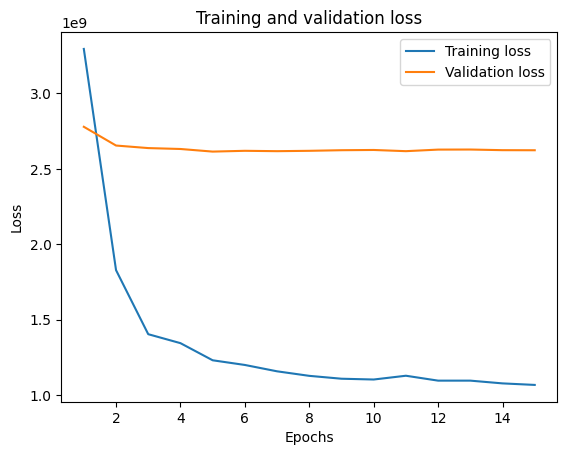

In [69]:
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, label="Training loss")
plt.plot(epochs, val_loss_values, label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [70]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true).reshape(-1,1), np.array(y_pred).reshape(-1,1)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [71]:
predictions = model.predict(X_train)

mean_absolute_percentage_error(y_train, predictions)

80/80 [==============================] - 0s 780us/step


114.20053483458545

In [72]:
# Start Artificial Neural Network
final_model = keras.Sequential()

# Adding the input layer and the first hidden layer
final_model.add(keras.layers.Dense(units=256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)))
final_model.add(keras.layers.Dropout(0.5))

# Adding the second hidden layer
final_model.add(keras.layers.Dense(units=256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)))
final_model.add(keras.layers.Dropout(0.5))

# Adding the third hidden layer
final_model.add(keras.layers.Dense(units=256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)))
final_model.add(keras.layers.Dropout(0.5))

# Adding the output layer
final_model.add(keras.layers.Dense(units=1, activation='linear'))

# Learning rate schedule
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.9)

# Specify optimizer with learning rate schedule
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

# Compile NN
final_model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])


In [73]:
with open('dnn_model.pkl', 'wb') as f:
    pickle.dump(model, f)

INFO:tensorflow:Assets written to: C:\Users\YIXUAN~1\AppData\Local\Temp\tmpy32aubem\assets


INFO:tensorflow:Assets written to: C:\Users\YIXUAN~1\AppData\Local\Temp\tmpy32aubem\assets


In [74]:
with open('dnn_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

predictions = loaded_model.predict(X)
print(predictions)

100/100 [==============================] - 0s 800us/step
[[ -772.3952]
 [ 1067.3976]
 [-1072.9833]
 ...
 [ 1427.317 ]
 [  931.4284]
 [-1991.9576]]


In [75]:
# Define parameters
params = {
    'length': len(X),
    'dim': X.shape[1],
    'col': X.columns
}

# Initialize the Knockoffs object
knockoff_generator = Knockoffs()

# Generate knockoff variables
knockoff_variables = knockoff_generator.GenKnockoffs(X.values, params)

# Convert to DataFrame for easier handling
X_knockoff = pd.DataFrame(knockoff_variables, columns=X.columns)

print(X_knockoff.head())

    Peak viewers  Final price  is_historical_low  Peak viewers_shift_1  \
0  -42857.809489    -0.965949          -0.000003        -130693.995053   
1  -68364.878352     0.657155           0.000012         195638.611764   
2 -161788.019350    -0.927724          -0.000017           5278.016816   
3  -91755.203155    -0.762522          -0.000009        -277361.854158   
4   35702.435374    -0.335123          -0.000003         144122.474856   

   Peak viewers_shift_2  Peak viewers_shift_3  Peak viewers_shift_4  \
0         208959.155118         -37496.547754        -273779.942468   
1        -114225.821206         160201.952563         -32463.332592   
2          68489.917288         -71646.431206          60226.904744   
3          25028.785673         150900.414718           3102.278102   
4        -114087.045560         -96894.645047           8147.483781   

   Peak viewers_shift_5  Peak viewers_shift_6  Peak viewers_shift_7  ...  \
0         126709.671162           6588.390695       

In [76]:
# Unexpected error
import torch

from diagnostics import compute_diagnostics, ScatterCovariance

# Assuming X and X_knockoff are your original and knockoff variables

# Define alphas for MMD
alphas = [1., 2., 4., 8., 16., 32., 64., 128.]

# Convert data to torch tensors
X_t = torch.from_numpy(X.values).float()
X_knockoff_t = torch.from_numpy(X_knockoff.values).float()

# Compute diagnostics
results = compute_diagnostics(X_t, X_knockoff_t, alphas, verbose=True)
print(results)

(Self-corr) : 0.525250
Covariance.    Full swap: 7163853409260111134720.000000
     MMD.    Full swap: 0.000000
     KNN.    Full swap: 0.818868
  Energy.    Full swap: 9874.250000
Covariance. Partial swap: 7392683558126619721728.000000
     MMD. Partial swap: 0.000000
     KNN. Partial swap: 0.726415
  Energy. Partial swap: 9287.500000
       Metric     Swap         Value
0  Covariance     self  5.252502e-01
1  Covariance     full  7.163853e+21
2         MMD     full  0.000000e+00
3         KNN     full  8.188679e-01
4      Energy     full  9.874250e+03
5  Covariance  partial  7.392684e+21
6         MMD  partial  0.000000e+00
7         KNN  partial  7.264151e-01
8      Energy  partial  9.287500e+03


In [77]:
def causal_inference_knockoff(X, y, X_knockoff, final_model, params):
    """
    Perform causal inference using knockoff intervention.
    
    Args:
    X: np.ndarray - Original features.
    y: np.ndarray - Target variable.
    X_knockoff: np.ndarray - Knockoff features.
    final_model: Trained model to predict y from X.
    params: dict - Dictionary of parameters.
    
    Returns:
    causal_matrix: np.ndarray - Thresholded causal matrix.
    p_matrix: np.ndarray - Matrix of p-values.
    """

    # Convert X and X_knockoff to numpy arrays if they are pandas DataFrames
    if isinstance(X, pd.DataFrame):
        X = X.values
    if isinstance(X_knockoff, pd.DataFrame):
        X_knockoff = X_knockoff.values

    training_length = params.get('train_len')
    prediction_length = params.get('pred_len')
    num_windows = params.get('num_sliding_win')
    step_size = params.get('step_size')
    plot_path = params.get('plot_path')
    columns = params.get('col', [f'X{i}' for i in range(X.shape[1])])  # Default to 'X0', 'X1', ..., if 'col' is not provided
    num_samples = params.get('num_samples')
    
    if not training_length or not prediction_length or not num_windows or not step_size:
        raise ValueError("Missing required parameters in 'params' dictionary.")

    if not pathlib.Path(final_model).exists():
        raise FileNotFoundError(f"Model file {final_model} does not exist.")
    
    with open(final_model, 'rb') as f:
        model = pickle.load(f)
    
    causal_decisions = []
    p_values = []

    for i in range(X.shape[1]):
        feature_name = columns[i]
        print(f"Testing feature '{feature_name}' against target 'y'...")

        knockoff_sample = X_knockoff[:, i]
        mean = np.random.normal(0, 0.05, len(knockoff_sample)) + np.mean(X[:, i])
        outdist = np.random.normal(150, 120, len(knockoff_sample))
        uniform = np.random.uniform(np.min(X[:, i]), np.max(X[:, i]), len(knockoff_sample))
        interventionlist = [knockoff_sample, outdist[: len(knockoff_sample)], mean, uniform]
        intervention_methods = ['In-dist', 'Out-dist', 'Mean', 'Uniform']

        for m, intervene in enumerate(interventionlist):
            mselist, mselistint, mapelist, mapelistint = [], [], [], []
            for iter in range(num_windows):
                start = iter * step_size
                end = start + training_length + prediction_length

                X_train = X[start:start + training_length, :]
                y_train = y[start:start + training_length]
                X_test = X[start + training_length:end, :]
                y_test = y[start + training_length:end]

                X_test_int = X_test.copy()
                X_test_int[:, i] = intervene[start + training_length:end]

                y_pred = model.predict(X_test)
                y_pred_int = model.predict(X_test_int)

                mse = mean_squared_error(y_test, y_pred)
                mape = mean_absolute_percentage_error(y_test, y_pred)
                mseint = mean_squared_error(y_test, y_pred_int)
                mapeint = mean_absolute_percentage_error(y_test, y_pred_int)

                mselist.append(mse)
                mapelist.append(mape)
                mselistint.append(mseint)
                mapelistint.append(mapeint)

            # Statistical tests
            t, p = ks_2samp(mapelist, mapelistint)
            corr, p_val = spearmanr(mapelist, mapelistint)

            print(f"  Method: {intervention_methods[m]}, KS p-value: {p:.4f}, Spearman p-value: {p_val:.4f}")

            if p < 0.05:
                causal_decision = 1
            else:
                causal_decision = 0

            causal_decisions.append(causal_decision)
            p_values.append(p)

    # Reshape results into a matrix
    causal_matrix = np.array(causal_decisions).reshape(X.shape[1], len(intervention_methods))
    p_matrix = np.array(p_values).reshape(X.shape[1], len(intervention_methods))

    # Print summary
    print("\nCausal Inference Summary:")
    for i in range(X.shape[1]):
        feature_name = columns[i]
        print(f"Feature '{feature_name}':")
        for m in range(len(intervention_methods)):
            print(f"  {intervention_methods[m]} - Causal Decision: {causal_matrix[i, m]}, P-Value: {p_matrix[i, m]:.4f}")

    return causal_matrix, p_matrix

# Example usage:
# params = {
#     'train_len': 100,
#     'pred_len': 10,
#     'num_sliding_win': 30,
#     'step_size': 10,
#     'plot_path': './plots/',
#     'col': ['X1', 'X2', 'X3', 'X4'],
#     'num_samples': 50
# }
# causal_matrix, p_matrix = causal_inference_knockoff(X, y, X_knockoff, 'final_model.pkl', params)



In [78]:
default_params = {
    'epochs': 50,
    'pred_len': 12,
    'train_len': 500,
    'num_layers': 4,
    'num_samples': 40,
    'num_cells': 20,
    'dropout_rate': 0.1,
    'win_size': 1,
    'step_size': 3,
    'num_sliding_win': 20,
    'sliding_win_size': 100,
    'dim': 5,
    'batch_size': 32
}

In [79]:
causal_matrix, p_matrix = causal_inference_knockoff(X, y, X_knockoff, 'dnn_model.pkl', default_params)

Testing feature 'X0' against target 'y'...
1/1 [==============================] - 0s 17ms/step
  Method: In-dist, KS p-value: 0.3356, Spearman p-value: 0.0000
1/1 [==============================] - 0s 16ms/step
  Method: Out-dist, KS p-value: 0.8320, Spearman p-value: 0.0000
1/1 [==============================] - 0s 18ms/step
  Method: Mean, KS p-value: 0.8320, Spearman p-value: 0.0000
1/1 [==============================] - 0s 18ms/step
  Method: Uniform, KS p-value: 0.5713, Spearman p-value: 0.0006
Testing feature 'X1' against target 'y'...
1/1 [==============================] - 0s 16ms/step
  Method: In-dist, KS p-value: 1.0000, Spearman p-value: 0.0000
1/1 [==============================] - 0s 16ms/step
  Method: Out-dist, KS p-value: 1.0000, Spearman p-value: 0.0000
1/1 [==============================] - 0s 16ms/step
  Method: Mean, KS p-value: 1.0000, Spearman p-value: 0.0000
1/1 [==============================] - 0s 17ms/step
  Method: Uniform, KS p-value: 1.0000, Spearman p-valu

In [80]:
# Print the results
print("Causal Matrix (Thresholded):")
print(causal_matrix)
print("P-Value Matrix:")
print(p_matrix)

Causal Matrix (Thresholded):
[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 1]
 [0 0 0 0]
 [0 0 0 1]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 1]
 [0 0 0 1]
 [0 0 0 1]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]]
P-Value Matrix:
[[0.33559098 0.83196961 0.83196961 0.571336  ]
 [1.         1.         1.         1.        ]
 [1.         1.         1.         1.        ]
 [0.571336   0.33559098 0.33559098 0.571336  ]
 [0.571336   0.83196961 0.83196961 0.03354166]
 [0.98313688 0.83196961 0.83196961 0.83196961]
 [1.         0.83196961 0.83196961 0.00396729]
 [0.99999239 0.98313688 0.98313688 0.33559098]
 [0.83196961 0.83196961 0.83196961 0.83196961]
 [0.83196961 0.98313688 0.98313688 0.17453301]
 [0.83196961 0.83196961 0.83196961 0.01229861]
 [0.98313688 0.83196961 0.83196961 0.03354166]
 [0.98313688 0.33559098 0.33559098 0.03354166]
 [0.83196961 0.98313688 

In [81]:
# Create a dataframe to match the column names with the output
causal_df = pd.DataFrame(causal_matrix, index=params['col'], columns=['In-dist', 'Out-dist', 'Mean', 'Uniform'])
p_values_df = pd.DataFrame(p_matrix, index=params['col'], columns=['In-dist', 'Out-dist', 'Mean', 'Uniform'])


In [82]:
causal_df

,In-dist,Out-dist,Mean,Uniform
Peak viewers,0,0,0,0
Final price,0,0,0,0
is_historical_low,0,0,0,0
Peak viewers_shift_1,0,0,0,0
Peak viewers_shift_2,0,0,0,1
Peak viewers_shift_3,0,0,0,0
Peak viewers_shift_4,0,0,0,1
Peak viewers_shift_5,0,0,0,0
Peak viewers_shift_6,0,0,0,0
Peak viewers_shift_7,0,0,0,0


In [83]:
p_values_df

,In-dist,Out-dist,Mean,Uniform
Peak viewers,0.335591,0.831970,0.831970,0.571336
Final price,1.000000,1.000000,1.000000,1.000000
is_historical_low,1.000000,1.000000,1.000000,1.000000
Peak viewers_shift_1,0.571336,0.335591,0.335591,0.571336
Peak viewers_shift_2,0.571336,0.831970,0.831970,0.033542
Peak viewers_shift_3,0.983137,0.831970,0.831970,0.831970
Peak viewers_shift_4,1.000000,0.831970,0.831970,0.003967
Peak viewers_shift_5,0.999992,0.983137,0.983137,0.335591
Peak viewers_shift_6,0.831970,0.831970,0.831970,0.831970
Peak viewers_shift_7,0.831970,0.983137,0.983137,0.174533


In [84]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from scipy.stats import ks_2samp, spearmanr
import pickle
import pandas as pd
import pathlib
import tensorflow as tf
from tensorflow.keras.models import load_model

def plot_mape_distributions_for_variable(X, y, X_knockoff, final_model_path, params, variable_index):
    """
    Plot the MAPE distributions comparing original and knockoff interventions for a specific variable.
    
    Args:
    X: np.ndarray or pd.DataFrame - Original features.
    y: np.ndarray or pd.Series - Target variable.
    X_knockoff: np.ndarray or pd.DataFrame - Knockoff features.
    final_model_path: str - Path to the trained model file.
    params: dict - Dictionary of parameters.
    variable_index: int - Index of the variable to test.
    """
    # Convert X, y, and X_knockoff to numpy arrays if they are pandas DataFrames
    if isinstance(X, pd.DataFrame):
        X = X.values
    if isinstance(y, pd.Series):
        y = y.values
    if isinstance(X_knockoff, pd.DataFrame):
        X_knockoff = X_knockoff.values
        
    plot_path = params.get('plot_path')
    training_length = params['train_len']
    prediction_length = params['pred_len']
    num_windows = params['num_sliding_win']
    step_size = params['step_size']
    columns = params.get('col', [f'X{i}' for i in range(X.shape[1])])  # Default to 'X0', 'X1', ..., if 'col' is not provided

    feature_name = columns[variable_index]

    # Load the model (handle both traditional pickled models and Keras models)
    if final_model_path.endswith('.pkl'):
        with open(final_model_path, 'rb') as f:
            model = pickle.load(f)
    else:
        model = load_model(final_model_path)

    knockoff_sample = X_knockoff[:, variable_index]
    mean = np.random.normal(0, 0.05, len(knockoff_sample)) + np.mean(X[:, variable_index])
    outdist = np.random.normal(150, 120, len(knockoff_sample))
    uniform = np.random.uniform(np.min(X[:, variable_index]), np.max(X[:, variable_index]), len(knockoff_sample))
    interventionlist = [knockoff_sample, outdist[: len(knockoff_sample)], mean, uniform]
    intervention_methods = ['In-dist', 'Out-dist', 'Mean', 'Uniform']

    mapelist = {method: [] for method in intervention_methods}
    mapelistint = {method: [] for method in intervention_methods}

    for m, intervene in enumerate(interventionlist):
        for iter in range(num_windows):
            start = iter * step_size
            end = start + training_length + prediction_length

            X_train = X[start:start + training_length, :]
            y_train = y[start:start + training_length]
            X_test = X[start + training_length:end, :]
            y_test = y[start + training_length:end]

            X_test_int = X_test.copy()
            X_test_int[:, variable_index] = intervene[start + training_length:end]

            y_pred = model.predict(X_test,verbose = 0)
            y_pred_int = model.predict(X_test_int, verbose = 0)

            mape = mean_absolute_percentage_error(y_test, y_pred)
            mapeint = mean_absolute_percentage_error(y_test, y_pred_int)

            mapelist[intervention_methods[m]].append(mape)
            mapelistint[intervention_methods[m]].append(mapeint)

    # Plot MAPE distributions for the specified variable
    plt.figure(figsize=(14, 7))
    for i, method in enumerate(intervention_methods):
        plt.subplot(2, 2, i+1)
        sns.kdeplot(mapelist[method], label='Original', color='blue', shade=True)
        sns.kdeplot(mapelistint[method], label='Knockoff', color='red', shade=True)
        plt.title(f"MAPE Distribution for {method}")
        plt.xlabel("MAPE")
        plt.ylabel("Density")
        plt.legend()
    
    plt.suptitle(f"MAPE Distributions for Feature '{feature_name}'")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(f"{plot_path}/mape_distributions_{feature_name}.png")
    plt.show()

# Example usage:
# params = {
#     'train_len': 100,
#     'pred_len': 10,
#     'num_sliding_win': 30,
#     'step_size': 10,
#     'plot_path': './plots/',
#     'col': ['X1', 'X2', 'X3', 'X4'],
#     'num_samples': 50
# }
# plot_mape_distributions_for_variable(X, y, X_knockoff, 'dnn_model.pkl', params, variable_index=7)


In [85]:
default_params = {
    'plot_path' : 'C:\\Users\\Yixuan Liu\\Downloads\\DSO 585',
    'epochs': 50,
    'pred_len': 12,
    'train_len': 500,
    'num_layers': 4,
    'num_samples': 40,
    'num_cells': 20,
    'dropout_rate': 0.1,
    'win_size': 1,
    'step_size': 3,
    'num_sliding_win': 20,
    'sliding_win_size': 100,
    'dim': 5,
    'batch_size': 32
}

In [86]:
indices_with_in_dist_1 = causal_df.reset_index().index[causal_df['In-dist'] == 1].tolist()
variables_with_in_dist_1 = causal_df.index[causal_df['In-dist'] == 1].tolist()

In [87]:
variables_with_in_dist_1

[]

In [88]:
indices_with_in_dist_1

[]

In [89]:
for i in range(len(indices_with_in_dist_1)):
    plot_mape_distributions_for_variable(X, y, X_knockoff, 'dnn_model.pkl', default_params, indices_with_in_dist_1[i])

# 5. LPCMCI

In [90]:
data = raw[['DateTime', 'Players', 'Peak viewers']]

In [91]:
data.loc[:, 'DateTime'] = pd.to_datetime(data['DateTime'], format='%m/%d/%y')

In [92]:
data = data.set_index('DateTime')

In [93]:
data = data.dropna()

In [94]:
data_diff = data.diff()

In [95]:
data_diff = data_diff.dropna()

<Axes: xlabel='DateTime'>

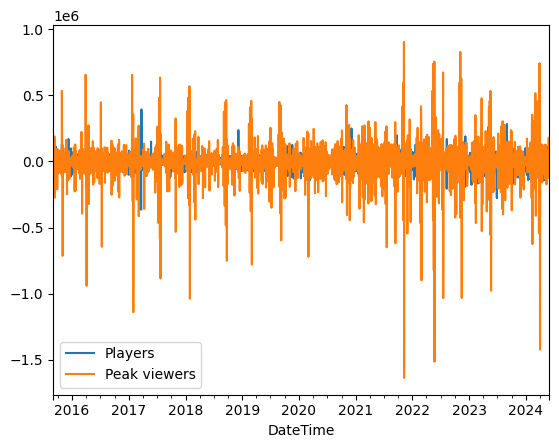

In [96]:
data_diff.plot()

In [97]:
Players = data_diff[['Players']]
Viewers = data_diff[['Peak viewers']]

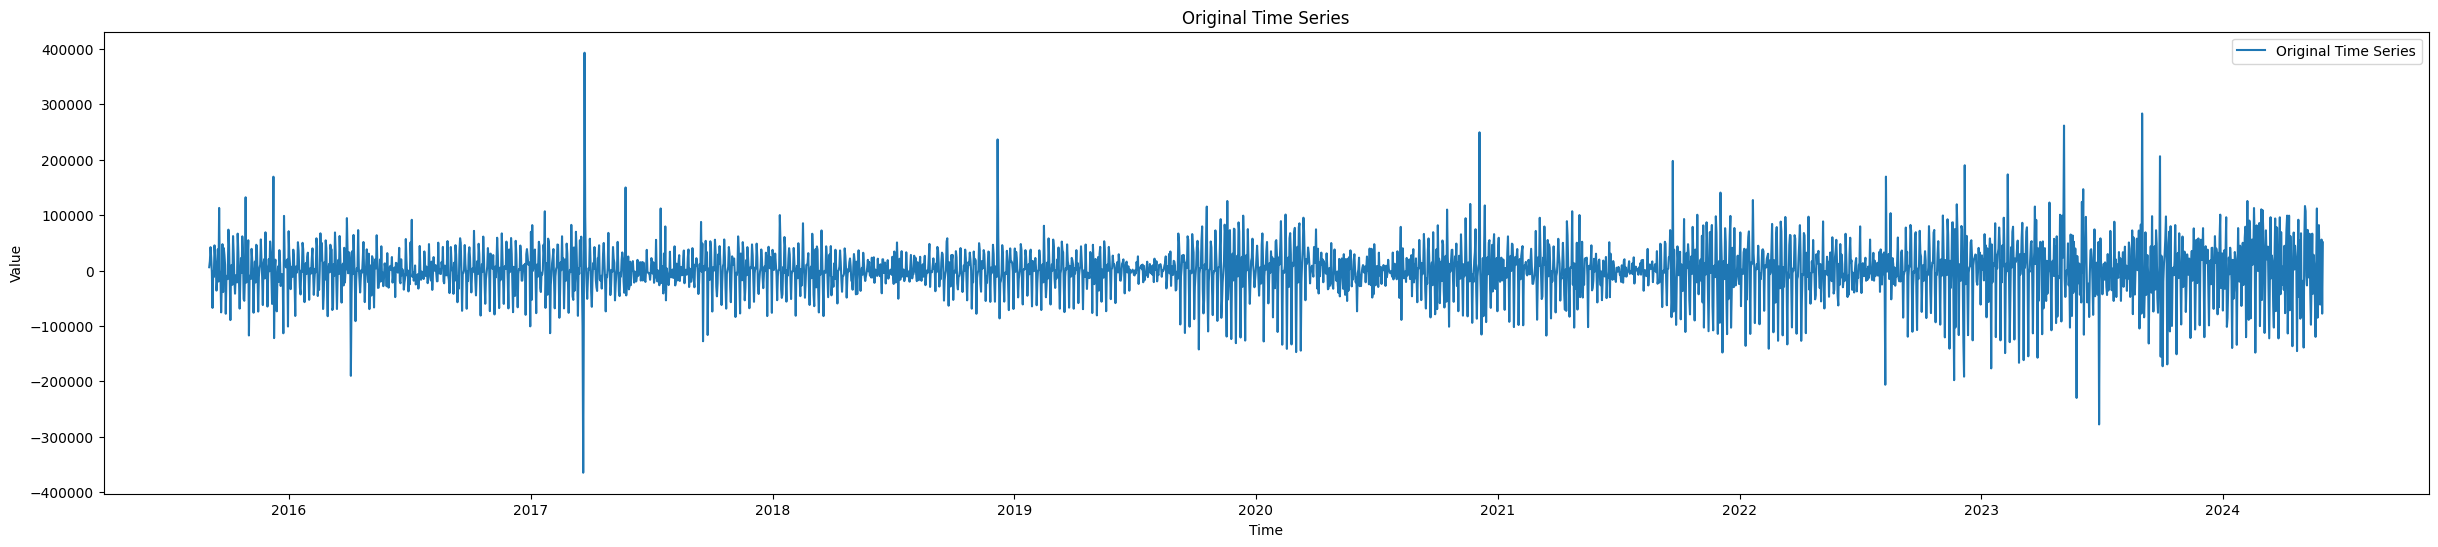

In [98]:
# Plot the original time series
plt.figure(figsize=(30, 6))
plt.plot(Players, label='Original Time Series')
plt.title('Original Time Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

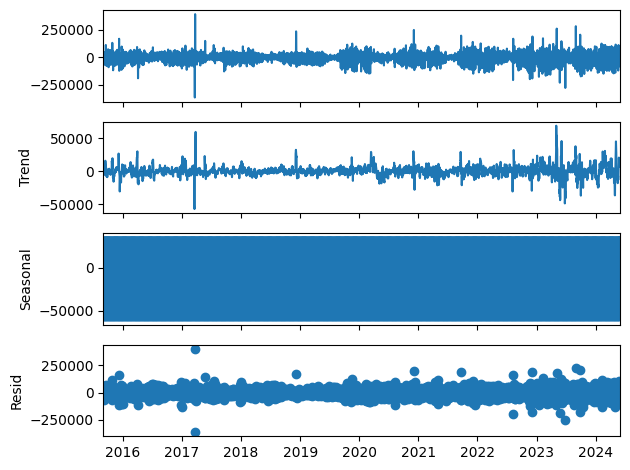

In [99]:
# Decompose the time series
result = seasonal_decompose(Players, model='additive', period = 7)

# Plot the decomposed components
result.plot()
plt.show()

In [100]:
# Deseasonalize the time series
deseasonalized_player = Players['Players'] - result.seasonal

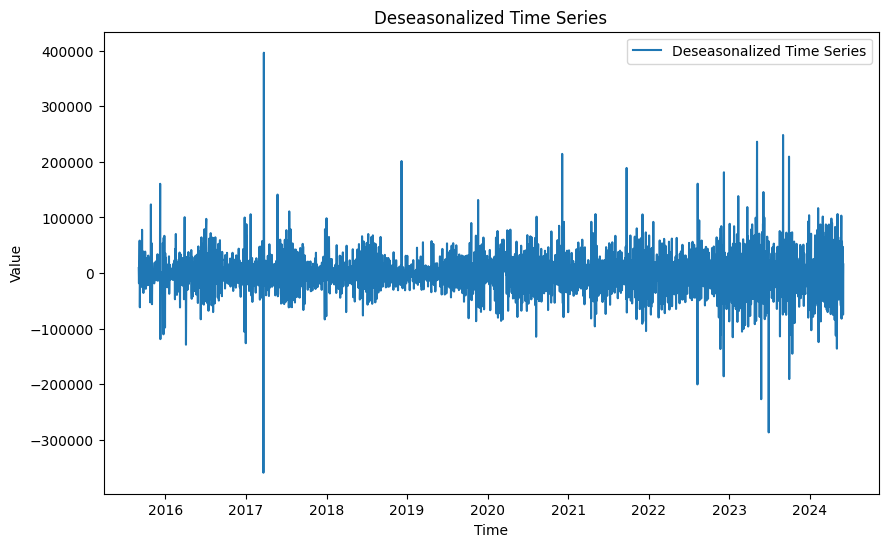

In [101]:
# Plot the deseasonalized time series
plt.figure(figsize=(10, 6))
plt.plot(deseasonalized_player, label='Deseasonalized Time Series')
plt.title('Deseasonalized Time Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [102]:
viewer = data_diff['Peak viewers']

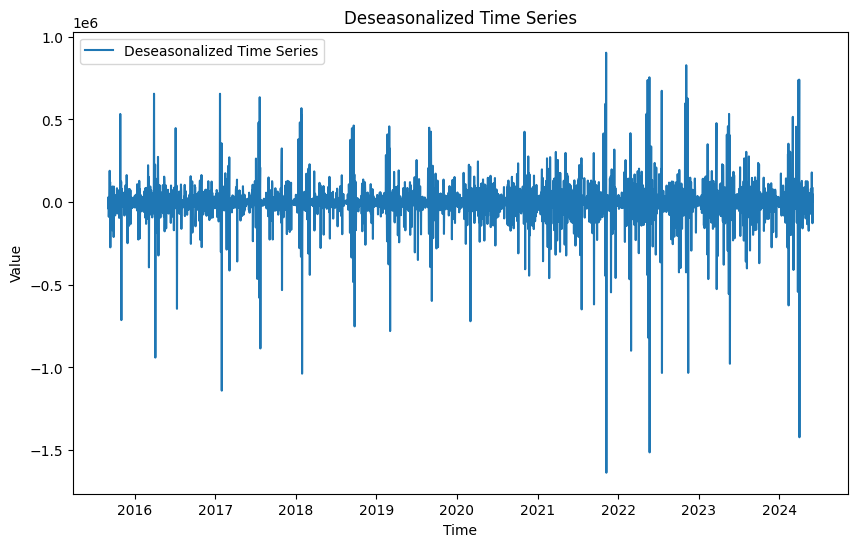

In [103]:
# Plot the deseasonalized time series
plt.figure(figsize=(10, 6))
plt.plot(viewer, label='Deseasonalized Time Series')
plt.title('Deseasonalized Time Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [104]:
df = pd.concat([deseasonalized_player, viewer], axis=1)

In [105]:
df.columns = ['deseasonalized_player_diff', 'viewer_diff']

In [106]:
type(df['deseasonalized_player_diff'].values)

numpy.ndarray

In [107]:
dt = np.column_stack((df['viewer_diff'].values, df['deseasonalized_player_diff'].values))

In [108]:
dt

array([[ -36506.        ,    9102.88058401],
       [  27575.        ,  -18387.40952588],
       [  31283.        ,   16763.68121196],
       ...,
       [  50137.        ,   47074.8385118 ],
       [-127648.        ,  -74631.11941599],
       [  83512.        ,   15676.59047412]])

In [109]:
var_names = ['viewer_diff', 'deseasonalized_player_diff']

In [110]:
dataframe = pp.DataFrame(dt, var_names=var_names)
tau_max = 14

# Set up PCMCI with ParCorr (Partial Correlation) as the independence test
parcorr = ParCorr(significance='analytic')
lpcmci = LPCMCI(dataframe=dataframe, cond_ind_test=parcorr, verbosity=1)

# Run Latent PCMCI (this step is a placeholder; actual implementation may vary)
results = lpcmci.run_lpcmci(tau_max=tau_max, pc_alpha=0.05)


Starting preliminary phase  1

Starting test phase

p = 0
(0,-13) independent (0, 0) given () union set()
(0,-12) independent (0, 0) given () union set()
(0,-11) independent (0, 0) given () union set()
(0,-8) independent (0, 0) given () union set()
(1,-8) independent (1, 0) given () union set()
Writing:   (0,-13) oL> (0, 0) ==> (0,-13)     (0, 0) 
Writing:   (0,-12) oL> (0, 0) ==> (0,-12)     (0, 0) 
Writing:   (0,-11) oL> (0, 0) ==> (0,-11)     (0, 0) 
Writing:   (0,-8) oL> (0, 0) ==> (0,-8)     (0, 0) 
Writing:   (1,-8) oL> (1, 0) ==> (1,-8)     (1, 0) 
(0, 0) independent (1, 0) given () union set()
(0, 0) independent (1, 0) given () union set()
Writing:   (0, 0) o?o (1, 0) ==> (0, 0)     (1, 0) 
Writing:   (1, 0) o?o (0, 0) ==> (1, 0)     (0, 0) 
(1,-1) independent (0, 0) given () union set()
Writing:   (1,-1) oL> (0, 0) ==> (1,-1)     (0, 0) 
(0,-2) independent (1, 0) given () union set()
(1,-2) independent (0, 0) given () union set()
Writing:   (1,-2) oL> (0, 0) ==> (1,-2)     (0

In [111]:
p_matrix = results['p_matrix']
print(results['p_matrix'].round(2))

[[[0.   0.   0.   0.   0.   0.   0.   0.01 0.11 0.   0.74 0.99 0.   0.01
   0.  ]
  [0.08 0.   0.02 0.16 0.86 0.13 0.81 0.7  0.92 0.13 1.   0.37 0.63 0.21
   0.76]]

 [[0.08 0.97 0.59 0.99 0.74 0.98 0.22 0.83 0.74 0.94 0.09 0.81 0.74 0.98
   0.93]
  [0.   0.   0.   0.   0.   0.   0.57 0.   0.1  0.   0.42 0.15 0.   0.87
   0.  ]]]


In [112]:
p_matrix.shape

(2, 2, 15)

In [113]:
def print_significant_causality(p_matrix, alpha=0.05):
    """
    Prints out significant causal links from the p_matrix.

    Parameters:
    - p_matrix: numpy array of shape (N, N, tau_max+1), p-values of the causal links
    - alpha: significance level to determine significant causality
    """
    N, _, tau_max_plus_1 = p_matrix.shape
    tau_max = tau_max_plus_1 - 1

    print(f"Significant causal links (p < {alpha}):")
    for i in range(N):
        for j in range(N):
            for tau in range(tau_max_plus_1):
                p_value = p_matrix[i, j, tau]
                if p_value < alpha:
                    print(f"Variable {i} at time t-{tau} -> Variable {j} at time t with p-value: {p_value:.5f}")


In [114]:
print_significant_causality(p_matrix, alpha=0.05)

Significant causal links (p < 0.05):
Variable 0 at time t-0 -> Variable 0 at time t with p-value: 0.00000
Variable 0 at time t-1 -> Variable 0 at time t with p-value: 0.00000
Variable 0 at time t-2 -> Variable 0 at time t with p-value: 0.00000
Variable 0 at time t-3 -> Variable 0 at time t with p-value: 0.00000
Variable 0 at time t-4 -> Variable 0 at time t with p-value: 0.00000
Variable 0 at time t-5 -> Variable 0 at time t with p-value: 0.00000
Variable 0 at time t-6 -> Variable 0 at time t with p-value: 0.00000
Variable 0 at time t-7 -> Variable 0 at time t with p-value: 0.00622
Variable 0 at time t-9 -> Variable 0 at time t with p-value: 0.00001
Variable 0 at time t-12 -> Variable 0 at time t with p-value: 0.00019
Variable 0 at time t-13 -> Variable 0 at time t with p-value: 0.00882
Variable 0 at time t-14 -> Variable 0 at time t with p-value: 0.00310
Variable 0 at time t-1 -> Variable 1 at time t with p-value: 0.00162
Variable 0 at time t-2 -> Variable 1 at time t with p-value: 0.

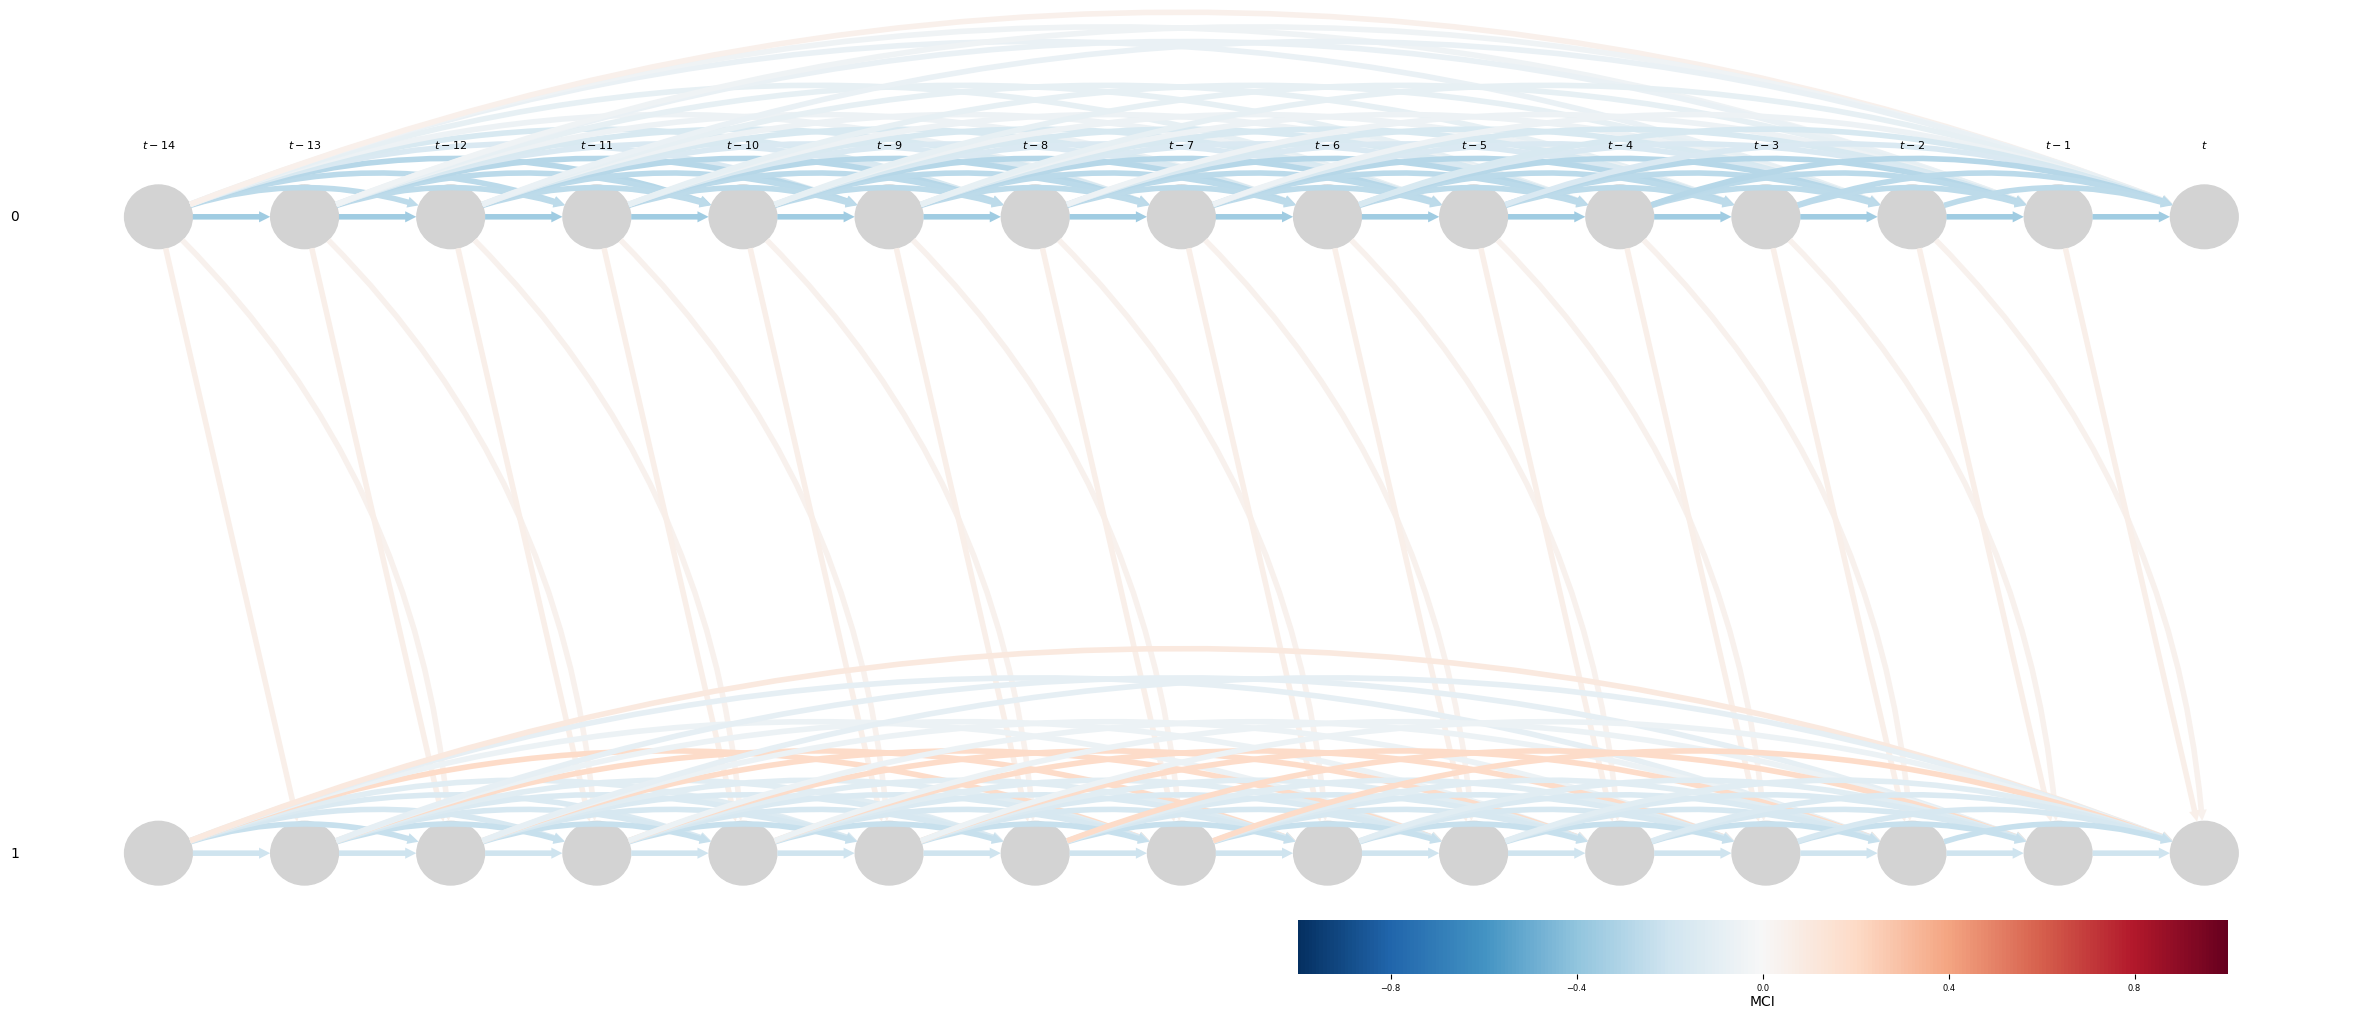

In [115]:
# Plot the learned time series DPAG
tp.plot_time_series_graph(graph=results['graph'],
                          val_matrix=results['val_matrix'],
                         figsize = (30,10))
plt.savefig(f"{'C:/Users/Yixuan Liu/Downloads/DSO 585'}/time_series_dag_cs2.png")
plt.show()

In [116]:
graph = results['graph']

In [117]:
graph

array([[['', '-->', '-->', '-->', '-->', '-->', '-->', '-->', '', '-->',
         '', '', '-->', '-->', '-->'],
        ['', '-->', '-->', '', '', '', '', '', '', '', '', '', '', '',
         '']],

       [['', '', '', '', '', '', '', '', '', '', '', '', '', '', ''],
        ['', '-->', '-->', '-->', '-->', '-->', '', '-->', '', '-->',
         '', '', '-->', '', '-->']]], dtype='<U3')

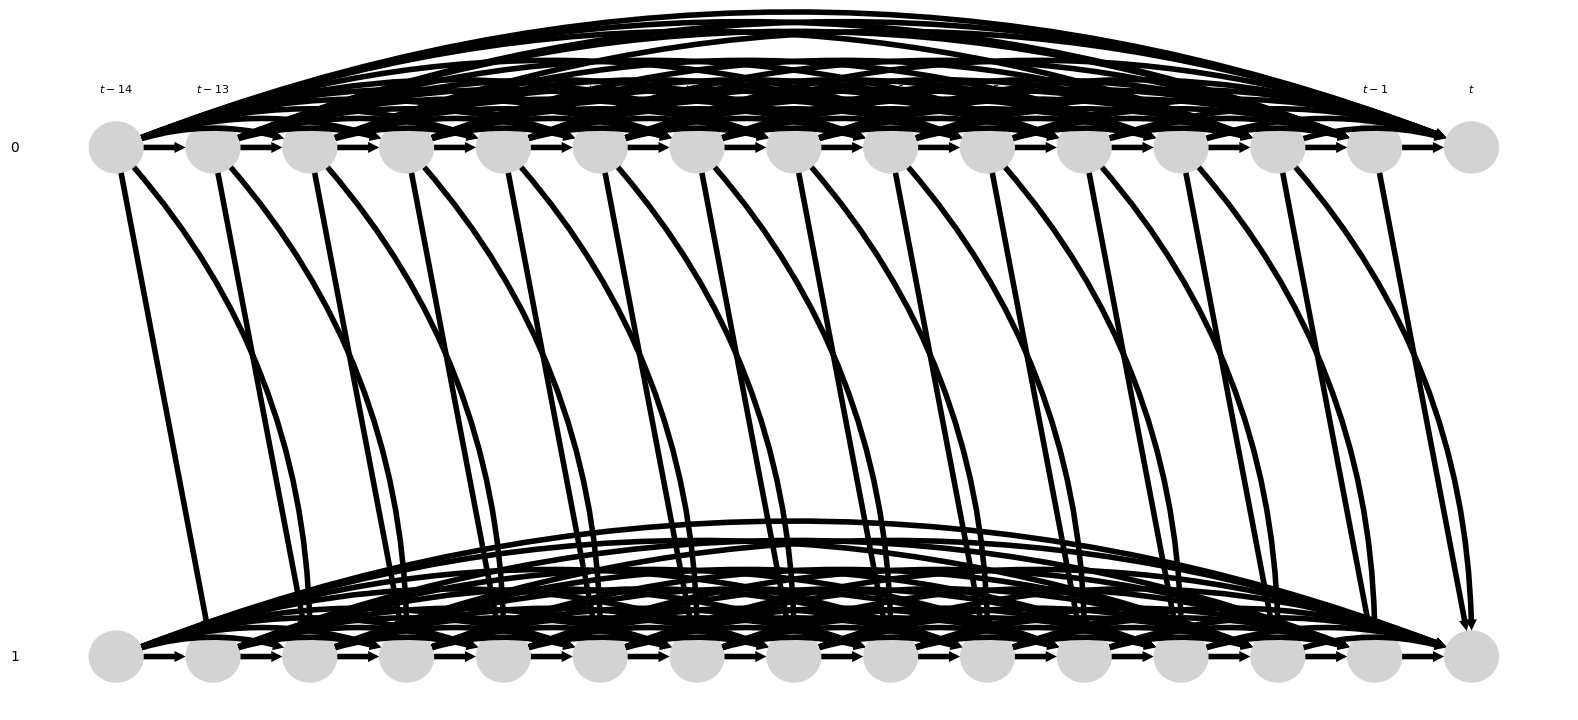

In [118]:
# Plot the learned time series DPAG
tp.plot_time_series_graph(graph=graph,
                         figsize = (20,8) )
plt.show()

In [119]:
# Define the cause (X) and effect (Y) variables based on simplified graph
X = [(0, -1), (0, -2)]  # predictor at lag -1 and lag -2
Y = [(1, 0)]  # target at current time
hidden_variables = []

# Initialize the CausalEffects object
causal_effects = CausalEffects(
    graph=graph,
    graph_type='stationary_dag',
    X=X,
    Y=Y,
    S=None,
    hidden_variables=[]
)

In [120]:
optimal_adjustment_set = causal_effects.get_optimal_set()

In [121]:
optimal_adjustment_set

[(1, -4),
 (0, -3),
 (1, -14),
 (1, -8),
 (1, -5),
 (1, -15),
 (1, -2),
 (1, -12),
 (1, -6),
 (1, -9),
 (1, -3),
 (1, -13),
 (1, -10),
 (1, -7)]

In [122]:
# Fit the causal effect model
causal_effects.fit_total_effect(
    dataframe=dataframe,
    estimator=LinearRegression(),
    adjustment_set='optimal',  # Use optimal adjustment set
    conditional_estimator=None,
    data_transform=None,
    mask_type=None
)

In [123]:

# Define `intervention_data` with the correct shape
# intervention_data should have the same number of columns as the length of X
intervention_data = np.ones((1, len(X)))  # Set the predictor to 1

# Predict the total effect of the intervention
y1 = causal_effects.predict_total_effect(intervention_data=intervention_data)
print("Predicted effect when predictor is 1: ", y1)

# Predict the effect of an intervention (setting predictor to 0)
intervention_data_zero = np.zeros((1, len(X)))  # Set the predictor to 0
y0 = causal_effects.predict_total_effect(intervention_data=intervention_data_zero)
print("Predicted effect when predictor is 0: ", y0)
# Calculate the average treatment effect
beta = (y1 - y0)
print("Estimated causal effect = %.4f" % beta)

Predicted effect when predictor is 1:  [248.10528446]
Predicted effect when predictor is 0:  [248.08179429]
Estimated causal effect = 0.0235
